# Silvery Beetle Species Classifier Neural Network
## Authors: Vinicio Soto y Marcela Hernández
### CICIMA UCR

- Trains and tests a neural network for species classification.
- Works with fiber optics reflectance measurements.
- Calculates the probability of a specimen being of a certain species.

In [31]:
import sys
import os
from pathlib import Path
# Get the current directory
current_directory = os.getcwd()
base_directory = Path(current_directory).parent
libraries_directory = base_directory/"libraries"
directories_in_path = [current_directory, base_directory, libraries_directory]

# Convert paths to strings and normalize for Windows
directories_in_path = [
    current_directory,
    str(base_directory),
    str(libraries_directory)
]

# Add directories to sys.path if not already present
for path in directories_in_path:
    path = os.path.normpath(path)  # Normalize path for Windows
    if path not in sys.path:
        sys.path.append(path)
        print(f"Added {path} to sys.path")


from spectraltools import Specimen_Collection, Spectrum, create_path_if_not_exists
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import re
import scipy
import socket #gets the machine name
import tensorflow as tf
from metrics import (Metric, feature_and_label_extractor, Gamma_First_Two_Peaks, Gamma_Arbitrary_Limits_Silver, 
                    Gamma_Area_Under_Curve_Naive, Gamma_Area_Under_Curve_First_Min_Cut, Gamma_Vector_Relative_Reflectance,
                    Wavelength_Vector, Critical_Points, Metric_Testbench)
from feature_engineering import get_aggregated_data
import seaborn as sns
from visualizations import scatter_plot_2_variables, scatter_plot_3_variables
import warnings


# Collection main paths

In [2]:
"""This section allows the user to choose their workplace location.
This is important if the user has multiple locations and operating systems in which this
script is run"""

# Training data is used when we are already certain of species and genera for a particular sample
training_data_is_used = True
debug = True

# Base folder 
base_folder = Path(base_directory)  # Same folder

# Define the location of the tables with information about the collections and its parent directory
collection_tables_main_path = base_folder / "collections"
l1050_collection_files_main_path = base_folder / "L1050_data"
fiber_optics_collection_files_main_path = base_folder / "avalight_spectrometer_data"

#Configuration file location

#configuration for collections
config_file_main_path = base_folder / "libraries" / "spectraltools"/ "spectral_config"

config_file_cicimaucr_l050_golden = config_file_main_path / "CICIMAUCR_L1050_GOLDEN.ini"
config_file_cicimaucr_l050_silver = config_file_main_path / "CICIMAUCR_L1050_SILVER.ini"
config_file_inbucr_avalight_silver = config_file_main_path / "INBUCR_AVALIGHT_SILVER.ini"
config_file_inbucr_l1050_golden = config_file_main_path / "INBUCR_L1050_GOLDEN.ini"
config_file_cicimaucr_avalight_silver = config_file_main_path / "CICIMAUCR_AVALIGHT_SILVER.ini"

#configuration for metrics
metric_config_main_path = base_folder / "libraries" / "metrics" / "spectral_config" / "metrics.ini"

# Define report location
report_location = base_folder / "reports" / "data_analysis"

# Define image counter generator
def yield_image_counter():
    for val in range(1, 100):
        yield val
image_counter = yield_image_counter()


## Spectrometer data main paths: L1050 data

In [3]:

# File location and metadata location for collection 1
l1050_angsol_collection_path = l1050_collection_files_main_path / "ANGSOL" / "average"
angsol_collection_metadata = collection_tables_main_path / "CICIMA-beetles-general-inventory - ANGSOL.txt"

# File location and metadata location for collection 2
l1050_cicimaucr_collection_path = l1050_collection_files_main_path / "TRA_data_CICIMA_INBUCR" / "CICIMAUCR" / "reflectance"
l1050_cicimaucr_collection_2_path = l1050_collection_files_main_path / "CICIMA-2024-01-REFLECTANCE" / "average"
l1050_cicimaucr_collection_3_path = l1050_collection_files_main_path / "CICIMA-2024-03-REFLECTANCE" / "without iris nor lens" / "average"
l1050_cicimaucr_collection_4_path = l1050_collection_files_main_path / "CICIMA-2024-05-REFLECTANCE" / "DORSAL" / "average"


cicima_ucr_metadata = collection_tables_main_path / "CICIMA-beetles-general-inventory - CICIMAUCR.txt"

# File location and metadata location for collection 3
l1050_inbucr_collection_path = l1050_collection_files_main_path / "INBUCR" / "average"
inbucr_metadata = collection_tables_main_path / "CICIMA-beetles-general-inventory - INBUCR.txt"

# File location and metadata location for collection 4
l1050_bioucr_collection_path = l1050_collection_files_main_path / "BIOUCR" / "average"
bioucr_metadata = collection_tables_main_path / "CICIMA-beetles-general-inventory - BIOUCR.txt"

# Aggregated data location, where averages and std will be saved when training data and retrieved when classifying spectra
agregated_data_location = base_folder / "aggregated_data"

## Spectrometer data main paths: Fiber optics data

In [4]:
fiber_optics_cicimaucr_collection_5_path = fiber_optics_collection_files_main_path / "CICIMAUCR"
fiber_optics_inbucr_collection_2_path = fiber_optics_collection_files_main_path / "INBUCR"

## Select collections for training and testing

In [5]:
#Set Specimen Collection objects

# Function to verify and print path
def verify_and_print_path(name, path):
    print(f"Input {name}: {path}")
    if not path.exists():
        print(f"Warning: Path does not exist: {path}")

# Create collections with debug output
print("Creating Specimen_Collection instances:")
verify_and_print_path("l1050_angsol_collection_path", l1050_angsol_collection_path)
verify_and_print_path("angsol_collection_metadata", angsol_collection_metadata)
angsol_collection = Specimen_Collection(
    name="ANGSOL",
    data_folder_path=l1050_angsol_collection_path,
    metadata_path=angsol_collection_metadata,
    quality="HIGH",
    config_file = config_file_cicimaucr_l050_golden,
)
angsol_collection.set_description(
    "ANGSOL collection has specimens that belong to Angel Solís. The confidence that we have about specimen identification is high."
)

verify_and_print_path("l1050_cicimaucr_collection_path", l1050_cicimaucr_collection_path)
verify_and_print_path("cicima_ucr_metadata", cicima_ucr_metadata)
l1050_cicimaucr_collection = Specimen_Collection(
    name="CICIMAUCR1",
    data_folder_path=l1050_cicimaucr_collection_path,
    metadata_path=cicima_ucr_metadata,
    quality="HIGH",
    config_file = config_file_cicimaucr_l050_golden,
)

verify_and_print_path("l1050_cicimaucr_collection_2_path", l1050_cicimaucr_collection_2_path)
l1050_cicimaucr_collection_2 = Specimen_Collection(
    name="CICIMAUCR2",
    data_folder_path=l1050_cicimaucr_collection_2_path,
    metadata_path=cicima_ucr_metadata,
    quality="HIGH",
    config_file = config_file_cicimaucr_l050_golden,
)

verify_and_print_path("l1050_cicimaucr_collection_3_path", l1050_cicimaucr_collection_3_path)
l1050_cicimaucr_collection_3 = Specimen_Collection(
    name="CICIMAUCR3",
    data_folder_path=l1050_cicimaucr_collection_3_path,
    metadata_path=cicima_ucr_metadata,
    quality="HIGH",
    config_file = config_file_cicimaucr_l050_golden,
)
#THIS
verify_and_print_path("fiber_optics_cicimaucr_collection_5_path", fiber_optics_cicimaucr_collection_5_path)
fiber_optics_cicimaucr_collection_5 = Specimen_Collection(
    name="CICIMAUCR5",
    data_folder_path=fiber_optics_cicimaucr_collection_5_path,
    metadata_path=cicima_ucr_metadata,
    quality="HIGH",
    config_file = config_file_cicimaucr_avalight_silver,
)
#THIS
verify_and_print_path("fiber_optics_inbucr_collection_2_path", fiber_optics_inbucr_collection_2_path)
fiber_optics_inbucr_collection_2 = Specimen_Collection(
    name="INBUCR2",
    data_folder_path=fiber_optics_inbucr_collection_2_path,
    metadata_path=inbucr_metadata,
    quality="HIGH",
    config_file = config_file_inbucr_avalight_silver,
)

verify_and_print_path("l1050_inbucr_collection_path", l1050_inbucr_collection_path)
verify_and_print_path("inbucr_metadata", inbucr_metadata)
l1050_inbucr_collection = Specimen_Collection(
    name="INBUCR",
    data_folder_path=l1050_inbucr_collection_path,
    metadata_path=inbucr_metadata,
    quality="MID",
    config_file = config_file_inbucr_l1050_golden,
)

verify_and_print_path("l1050_bioucr_collection_path", l1050_bioucr_collection_path)
verify_and_print_path("bioucr_metadata", bioucr_metadata)
l1050_bioucr_collection = Specimen_Collection(
    name="BIOUCR",
    data_folder_path=l1050_bioucr_collection_path,
    metadata_path=bioucr_metadata,
    quality="LOW",
    config_file = config_file_inbucr_l1050_golden, #todo create config file
)

training_collection_list = [
                    #angsol_collection,
                    #l1050_cicimaucr_collection,
                    #l1050_cicimaucr_collection_2,
                    #l1050_cicimaucr_collection_3,
                    fiber_optics_cicimaucr_collection_5,
                    fiber_optics_inbucr_collection_2,
                    #l1050_inbucr_collection,
                    #l1050_bioucr_collection,
                    ]
collection_names_set = set([collection.name for collection in training_collection_list])
collection_names = " ".join( sorted(collection_names_set))

prediction_collection_list = [
                    #angsol_collection,
                    #l1050_cicimaucr_collection,
                    #l1050_cicimaucr_collection_2,
                    #l1050_cicimaucr_collection_3,
                    fiber_optics_cicimaucr_collection_5,
                    fiber_optics_inbucr_collection_2,
                    #l1050_inbucr_collection,
                    #l1050_bioucr_collection,
                    ]
prediction_collection_names_set = set([collection.name for collection in training_collection_list])
prediction_collection_names = " ".join( sorted(collection_names_set))


Creating Specimen_Collection instances:
Input l1050_angsol_collection_path: C:\Users\esteb\escarabajos\L1050_data\ANGSOL\average
Input angsol_collection_metadata: C:\Users\esteb\escarabajos\collections\CICIMA-beetles-general-inventory - ANGSOL.txt
Input l1050_cicimaucr_collection_path: C:\Users\esteb\escarabajos\L1050_data\TRA_data_CICIMA_INBUCR\CICIMAUCR\reflectance
Input cicima_ucr_metadata: C:\Users\esteb\escarabajos\collections\CICIMA-beetles-general-inventory - CICIMAUCR.txt
Input l1050_cicimaucr_collection_2_path: C:\Users\esteb\escarabajos\L1050_data\CICIMA-2024-01-REFLECTANCE\average
Input l1050_cicimaucr_collection_3_path: C:\Users\esteb\escarabajos\L1050_data\CICIMA-2024-03-REFLECTANCE\without iris nor lens\average
Input fiber_optics_cicimaucr_collection_5_path: C:\Users\esteb\escarabajos\avalight_spectrometer_data\CICIMAUCR
Input fiber_optics_inbucr_collection_2_path: C:\Users\esteb\escarabajos\avalight_spectrometer_data\INBUCR
Input l1050_inbucr_collection_path: C:\Users\es

## Set Spectrum class parameters
# These parameters help calculate maxima and minima, set the range of valid wavelengths, distance between valid peaks.

## Filter spectra
#### Filters to only the target species


In [6]:
target_species = ["chrysargyrea", "optima"]

print("# of collections used in training: ", len(training_collection_list), "# of collections used in prediction: ", len(prediction_collection_list) )
#date

from datetime import datetime
current_date = datetime.now().date()

def get_filtered_spectra(collection_list, debug = False):

    all_spectra = []
    
    for collection in collection_list:
        if debug:
            print("collection:", collection)
        all_spectra += collection.get_spectra()
        if debug:
            print("all_spectra", len(all_spectra))
            print("species", set([item.get_species() for item in all_spectra]))

    filtered_spectra_by_species = [item for item in all_spectra if item.get_species() in target_species]
    return filtered_spectra_by_species
    
all_spectra = get_filtered_spectra(training_collection_list, debug= debug)
prediction_spectra  = get_filtered_spectra(prediction_collection_list, debug= debug) 

print("Number of valid spectra: ", len(all_spectra))
for spectrum in all_spectra:
    print(spectrum.get_species())

# of collections used in training:  2 # of collections used in prediction:  2
collection: CICIMAUCR5
Spectrum config: <Section: Spectrum>
min_wavelength 450.0 max_wavelength 1000.0 code: CICIMAUCR0044
Spectrum config: <Section: Spectrum>
min_wavelength 450.0 max_wavelength 1000.0 code: CICIMAUCR0044
Spectrum config: <Section: Spectrum>
min_wavelength 450.0 max_wavelength 1000.0 code: CICIMAUCR0044
Spectrum config: <Section: Spectrum>
min_wavelength 450.0 max_wavelength 1000.0 code: CICIMAUCR0173
Spectrum config: <Section: Spectrum>
min_wavelength 450.0 max_wavelength 1000.0 code: CICIMAUCR0173
Spectrum config: <Section: Spectrum>
min_wavelength 450.0 max_wavelength 1000.0 code: CICIMAUCR0178
Spectrum config: <Section: Spectrum>
min_wavelength 450.0 max_wavelength 1000.0 code: CICIMAUCR0178
Spectrum config: <Section: Spectrum>
min_wavelength 450.0 max_wavelength 1000.0 code: CICIMAUCR0179
Spectrum config: <Section: Spectrum>
min_wavelength 450.0 max_wavelength 1000.0 code: CICIMAUCR0179

## Get Metric values for each spectra
### This information will be used in feature engineering, metric statistics

In [7]:
gamma_first_two_peaks_data = feature_and_label_extractor(Metric = Gamma_First_Two_Peaks, 
                                                          config_file = metric_config_main_path, 
                                                          spectra =  all_spectra, 
                                                          debug = debug)

print(gamma_first_two_peaks_data)

cfg <Section: Gamma_First_Two_Peaks>
cfg <Section: Gamma_First_Two_Peaks>
cfg <Section: Gamma_First_Two_Peaks>
cfg <Section: Gamma_First_Two_Peaks>
cfg <Section: Gamma_First_Two_Peaks>
cfg <Section: Gamma_First_Two_Peaks>
cfg <Section: Gamma_First_Two_Peaks>
cfg <Section: Gamma_First_Two_Peaks>
[['CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0173', 'CICIMAUCR0173', 'INBUCR0216', 'INBUCR0216', 'INBUCR0216'], [np.float64(1.3257827468621162), np.float64(1.3201563330804535), np.float64(1.4172080834684848), np.float64(0.9918271953772824), np.float64(1.0844432238598865), np.float64(1.1775320463960735), np.float64(1.1471304903426303), np.float64(1.1283548762533997)], ['optima', 'optima', 'optima', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea']]


cfg <Section: Gamma_Arbitrary_Limits>
UV VIS MIN 450.0 UV VIS MAX: 780.0
POINT: 778.88 22.08314
ir_min_wavelength 450.0 ir_max_wavelength: 780.0
POINT: 801.02 22.72102
Filtering wavelengths


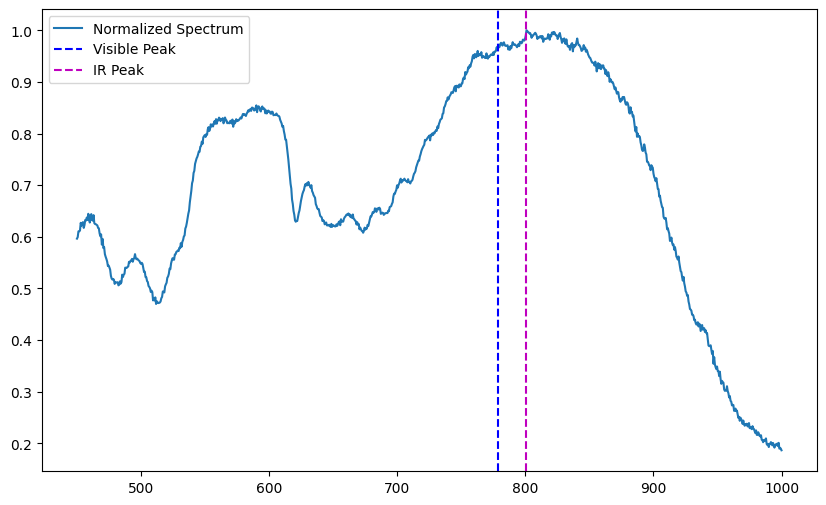

cfg <Section: Gamma_Arbitrary_Limits>
UV VIS MIN 450.0 UV VIS MAX: 780.0
POINT: 774.33 27.08904
ir_min_wavelength 450.0 ir_max_wavelength: 780.0
POINT: 812.35 27.57635
Filtering wavelengths


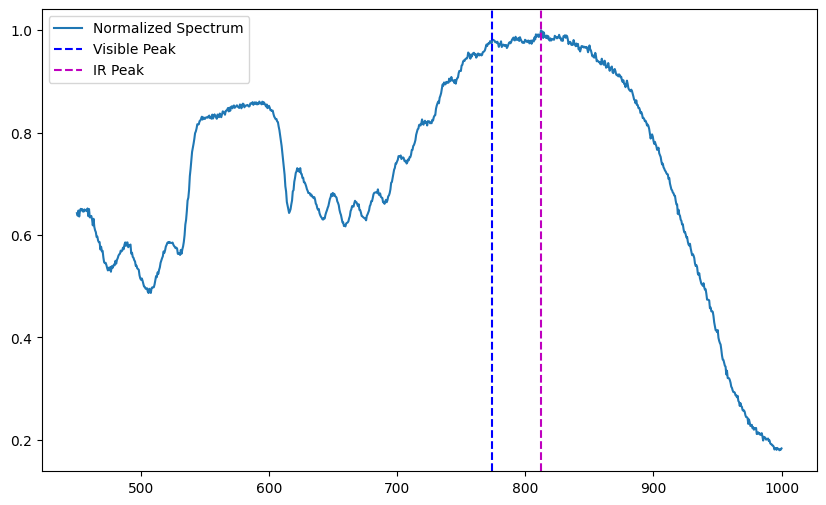

cfg <Section: Gamma_Arbitrary_Limits>
UV VIS MIN 450.0 UV VIS MAX: 780.0
POINT: 778.88 19.25865
ir_min_wavelength 450.0 ir_max_wavelength: 780.0
POINT: 823.09 20.27428
Filtering wavelengths


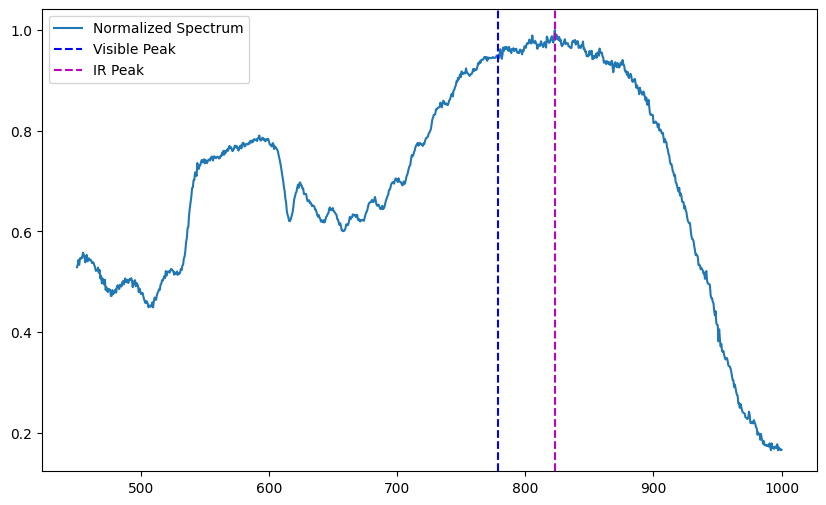

cfg <Section: Gamma_Arbitrary_Limits>
UV VIS MIN 450.0 UV VIS MAX: 780.0
POINT: 777.74 6.4136
ir_min_wavelength 450.0 ir_max_wavelength: 780.0
POINT: 829.31 6.55658
Filtering wavelengths


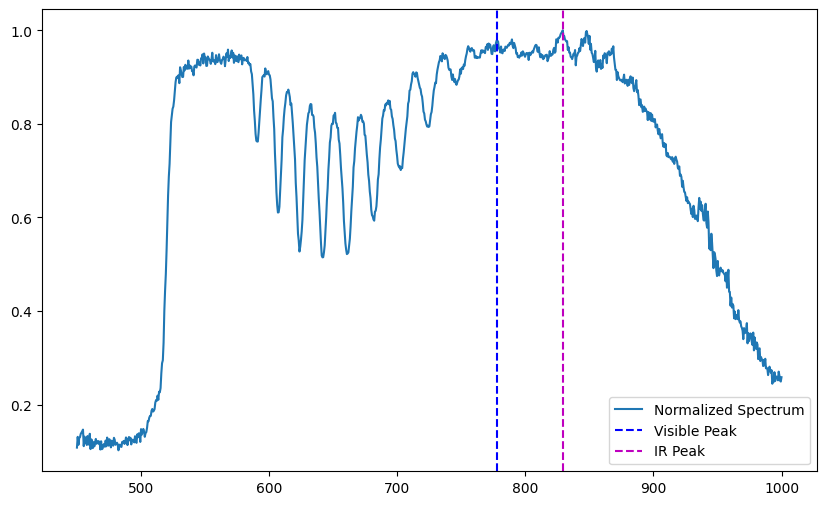

cfg <Section: Gamma_Arbitrary_Limits>
UV VIS MIN 450.0 UV VIS MAX: 780.0
POINT: 761.8 37.1148
ir_min_wavelength 450.0 ir_max_wavelength: 780.0
POINT: 820.83 38.74447
Filtering wavelengths


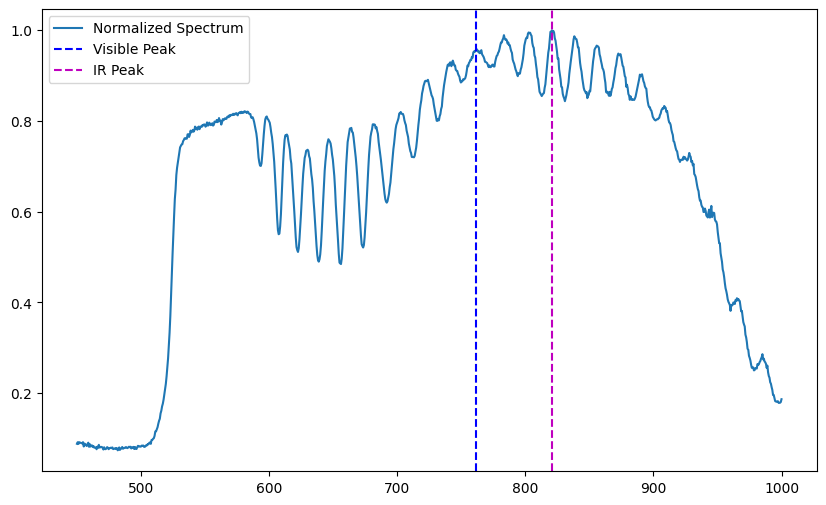

cfg <Section: Gamma_Arbitrary_Limits>
UV VIS MIN 450.0 UV VIS MAX: 780.0
POINT: 777.74 27.0142
ir_min_wavelength 450.0 ir_max_wavelength: 780.0
POINT: 795.35 27.26725
Filtering wavelengths


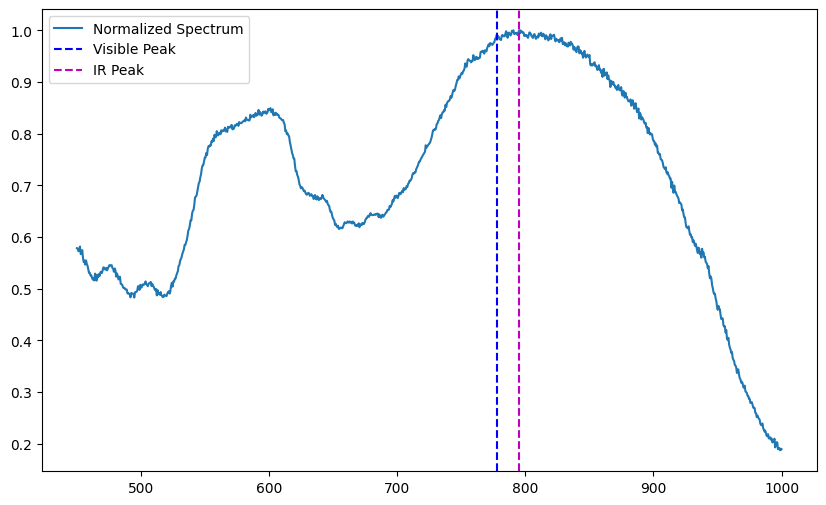

cfg <Section: Gamma_Arbitrary_Limits>
UV VIS MIN 450.0 UV VIS MAX: 780.0
POINT: 778.88 44.24286
ir_min_wavelength 450.0 ir_max_wavelength: 780.0
POINT: 796.48 44.30959
Filtering wavelengths


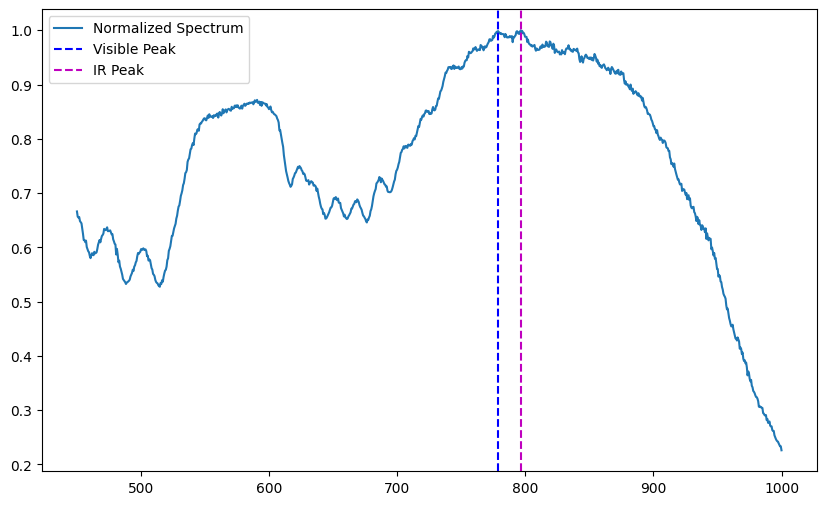

cfg <Section: Gamma_Arbitrary_Limits>
UV VIS MIN 450.0 UV VIS MAX: 780.0
POINT: 774.9 43.93705
ir_min_wavelength 450.0 ir_max_wavelength: 780.0
POINT: 816.31 44.27695
Filtering wavelengths


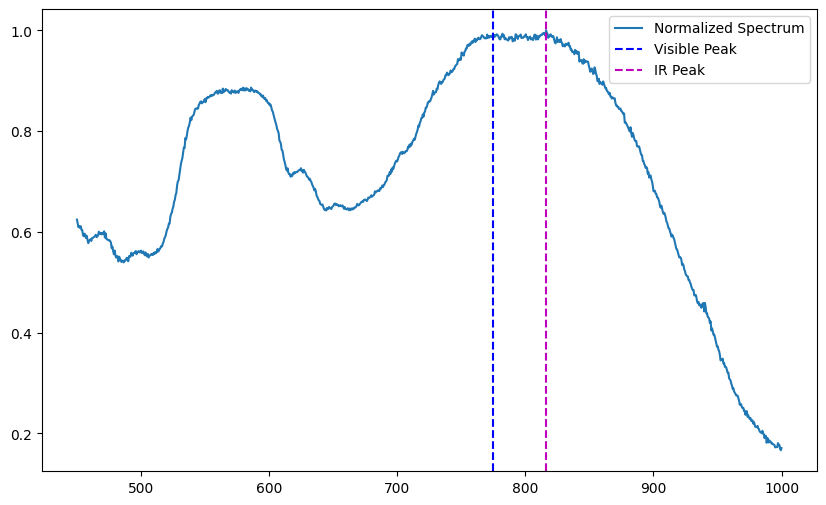

[['CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0173', 'CICIMAUCR0173', 'INBUCR0216', 'INBUCR0216', 'INBUCR0216'], [np.float64(0.9719255561590106), np.float64(0.9823286983230195), np.float64(0.9499054960274791), np.float64(0.9781928993469156), np.float64(0.9579379973451696), np.float64(0.9907196361936021), np.float64(0.9984940054737587), np.float64(0.992323319469837)], ['optima', 'optima', 'optima', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea']]


In [8]:
gamma_arbitrary_limits_data = feature_and_label_extractor(Metric = Gamma_Arbitrary_Limits_Silver, 
                                                          config_file = metric_config_main_path, 
                                                          spectra =  all_spectra, 
                                                          debug = debug)


print(gamma_arbitrary_limits_data)

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_Naive>
Filtering wavelengths


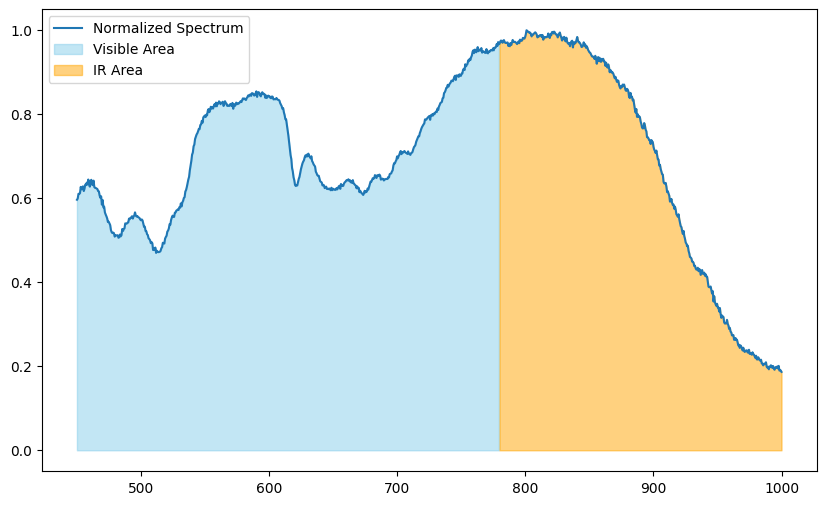

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_Naive>
Filtering wavelengths


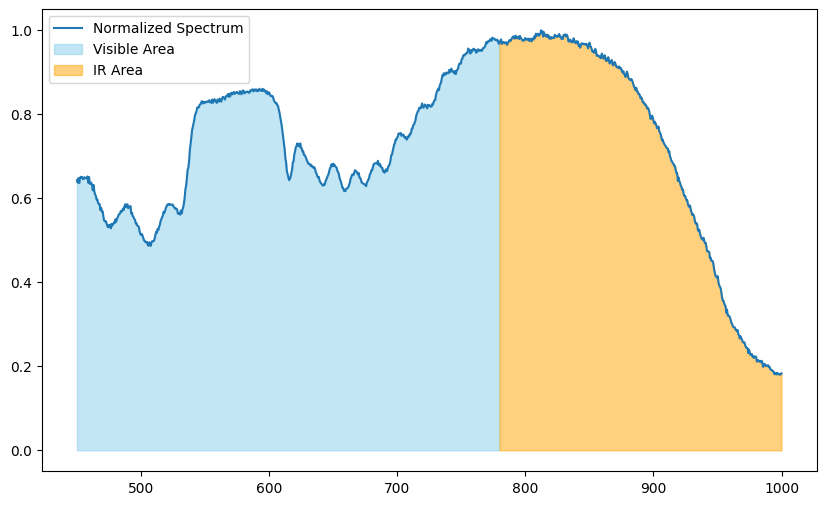

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_Naive>
Filtering wavelengths


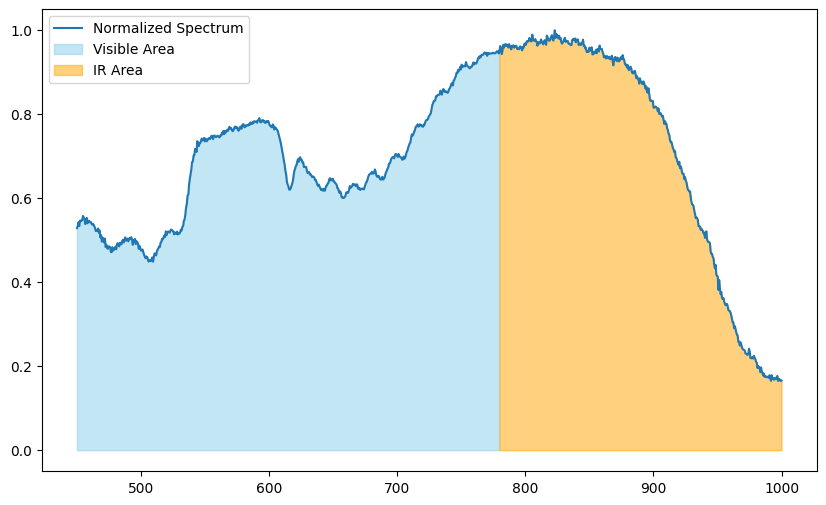

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_Naive>
Filtering wavelengths


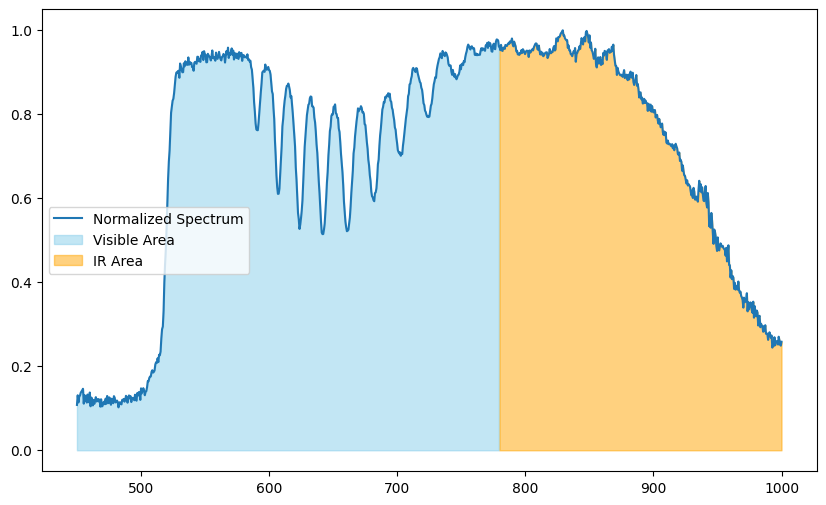

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_Naive>
Filtering wavelengths


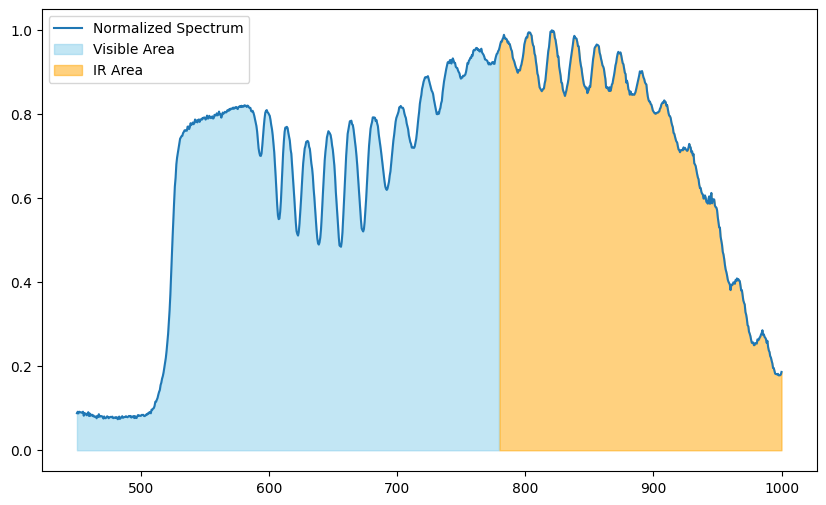

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_Naive>
Filtering wavelengths


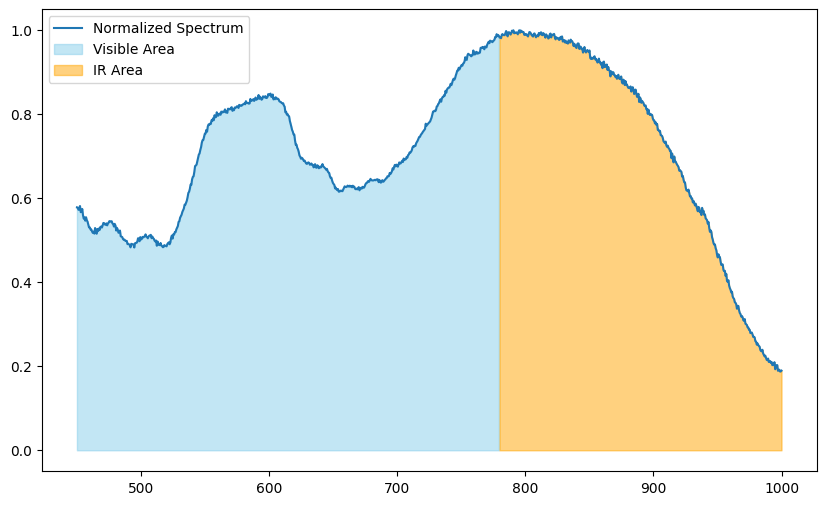

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_Naive>
Filtering wavelengths


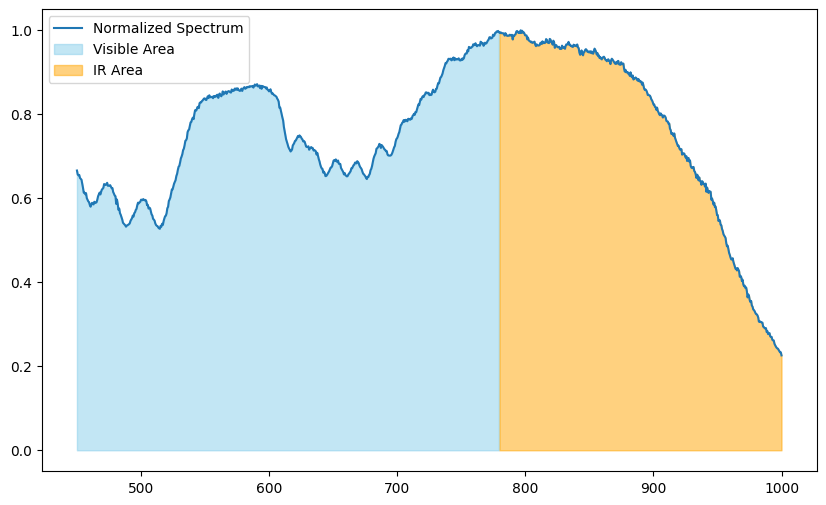

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_Naive>
Filtering wavelengths


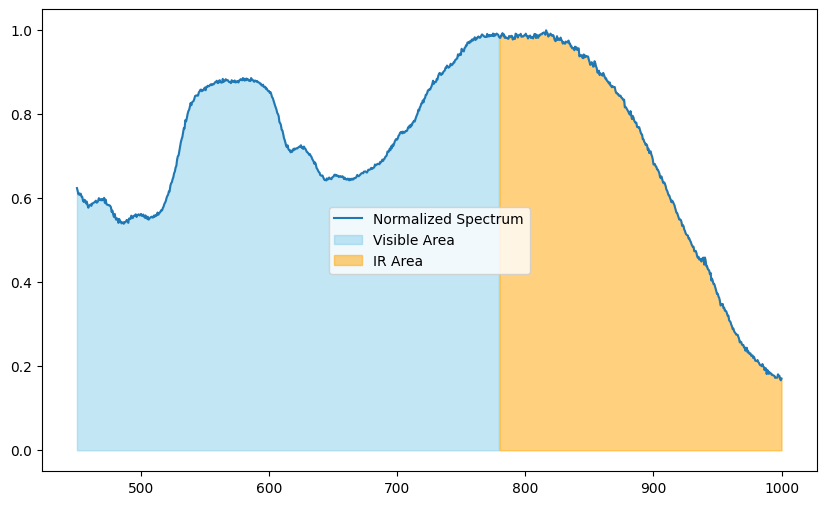

[['CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0173', 'CICIMAUCR0173', 'INBUCR0216', 'INBUCR0216', 'INBUCR0216'], [np.float64(0.6376070246949332), np.float64(0.6498506250930263), np.float64(0.7015645305119159), np.float64(0.7198180385365521), np.float64(0.7949310334927534), np.float64(0.6902161070019295), np.float64(0.6742917627899817), np.float64(0.6000935000557446)], ['optima', 'optima', 'optima', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea']]


In [9]:
gamma_area_under_curve_data = feature_and_label_extractor(Metric = Gamma_Area_Under_Curve_Naive, 
                                                          config_file = metric_config_main_path, 
                                                          spectra =  all_spectra, 
                                                          debug = debug)

print(gamma_area_under_curve_data)

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_First_Min_Cut>
Filtering wavelengths
PLOTTING


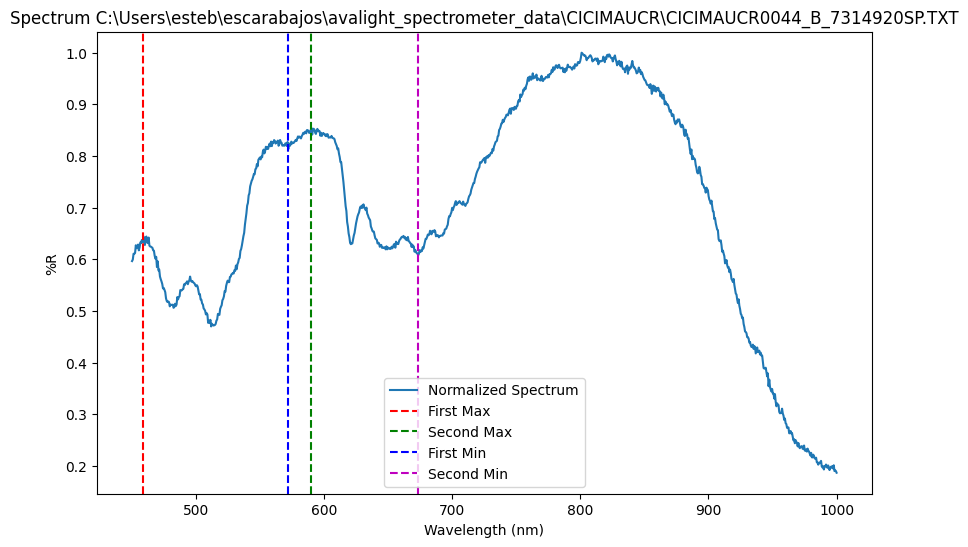

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_First_Min_Cut>
Filtering wavelengths
Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_First_Min_Cut>
Filtering wavelengths
PLOTTING


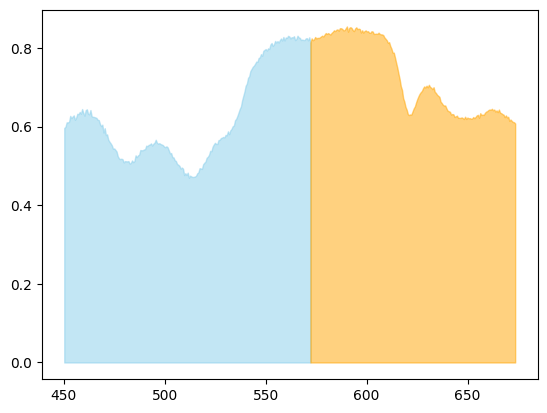

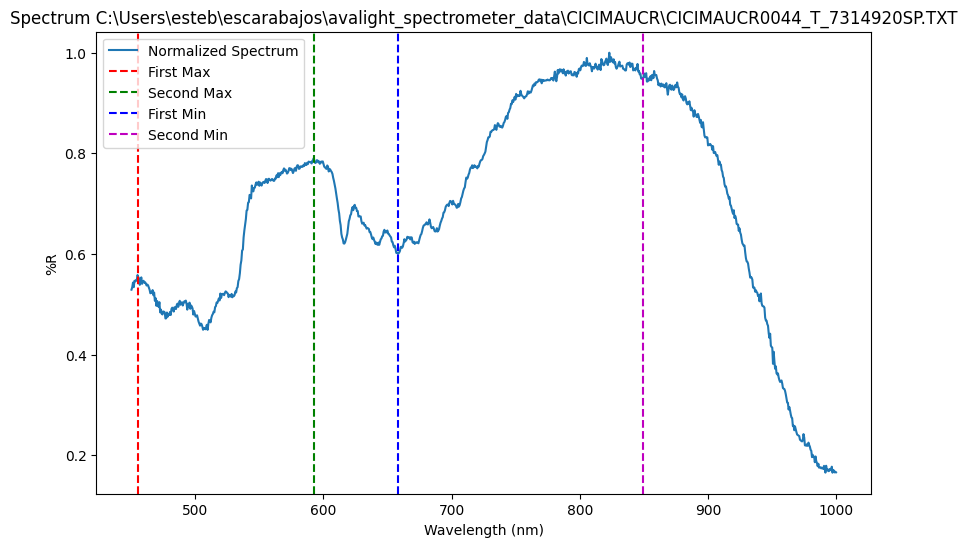

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_First_Min_Cut>
Filtering wavelengths
PLOTTING


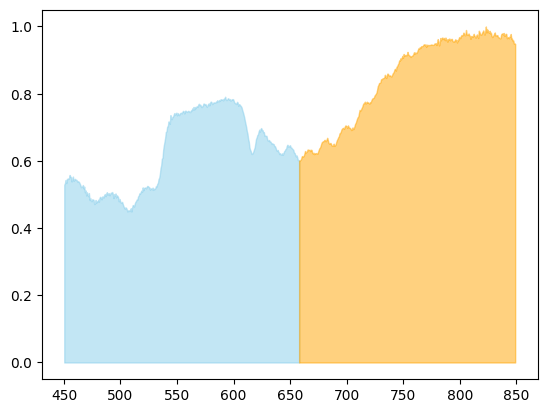

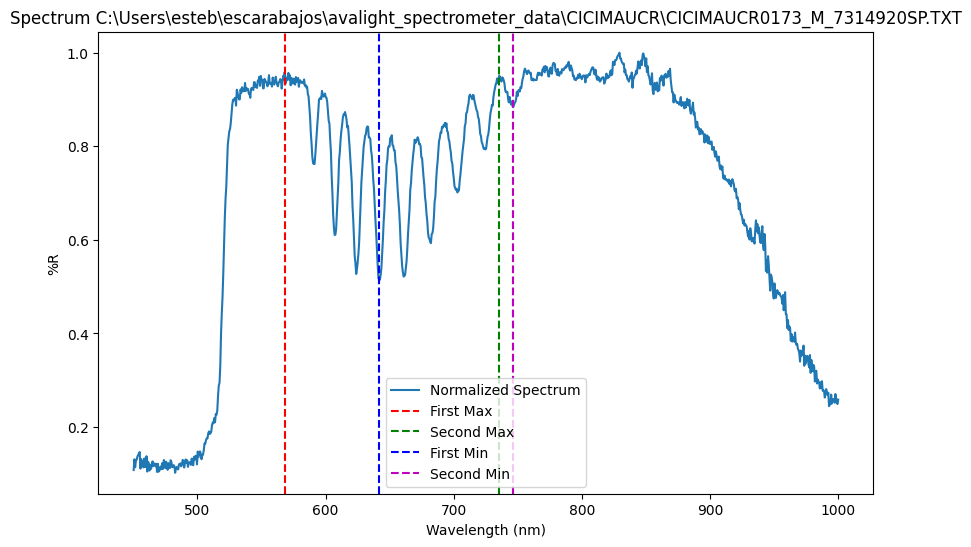

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_First_Min_Cut>
Filtering wavelengths
PLOTTING


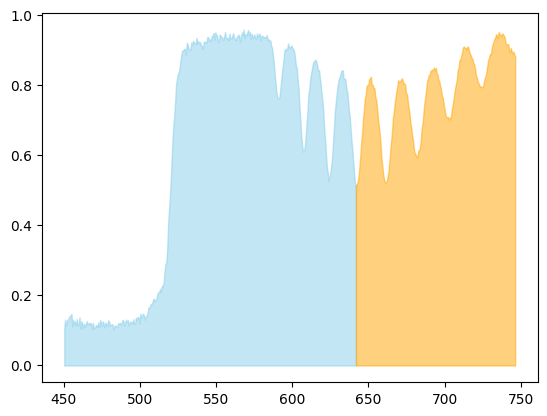

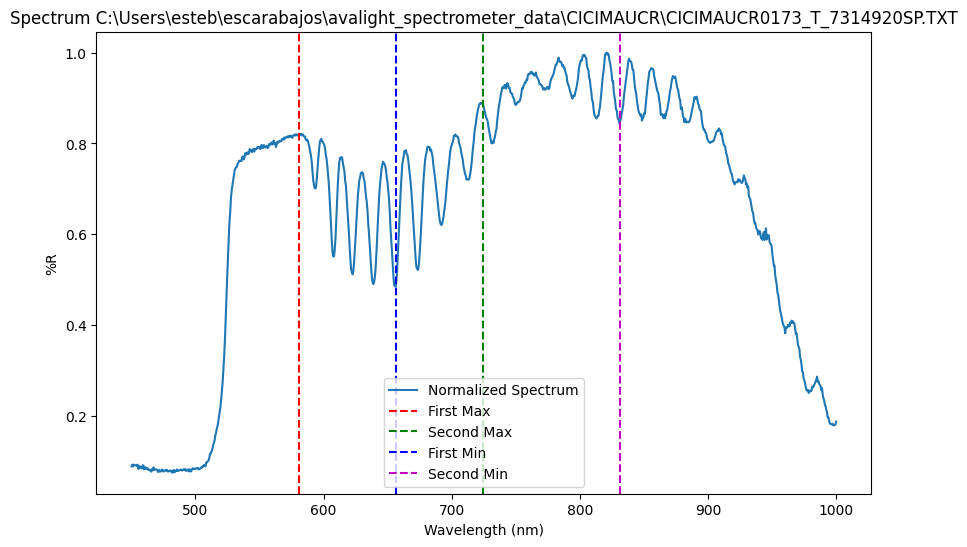

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_First_Min_Cut>
Filtering wavelengths
Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_First_Min_Cut>
Filtering wavelengths
PLOTTING


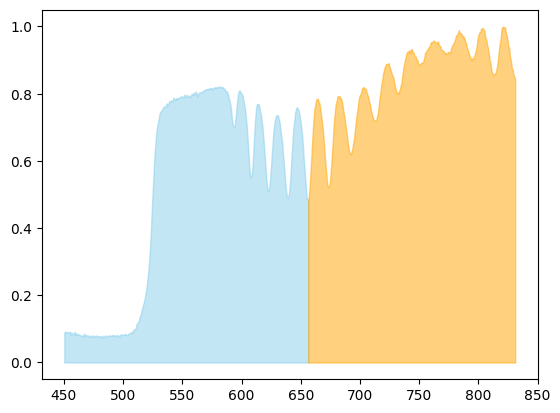

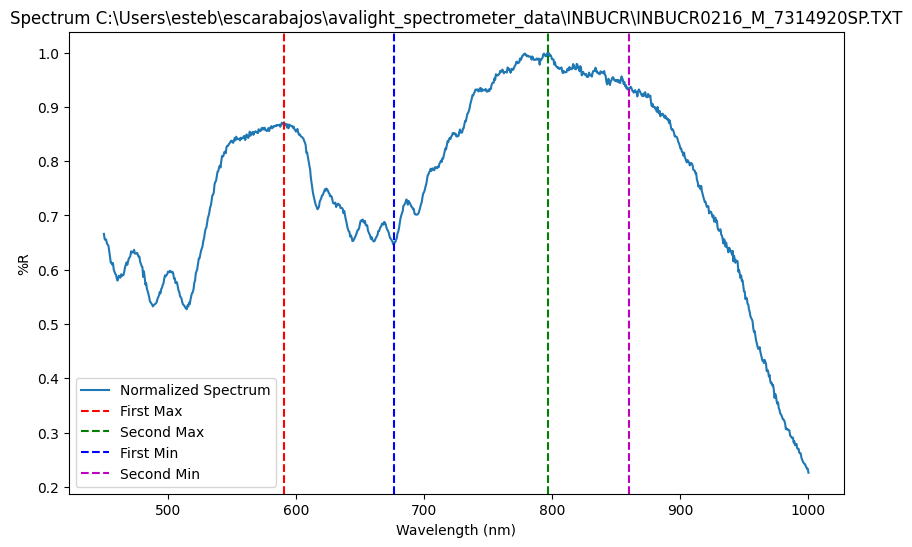

Available sections: ['Gamma_First_Two_Peaks', 'Gamma_Arbitrary_Limits', 'Gamma_Arbitrary_Limits_Silver', 'Gamma_Area_Under_Curve_Naive', 'Gamma_Area_Under_Curve_First_Min_Cut', 'Gamma_Vector_Relative_Reflectance', 'Wavelength_Vector', 'Critical_Points', 'Minimum_Points', 'Maximum_Points', 'Minimum_Points_Normalized', 'Maximum_Points_Normalized']
cfg <Section: Gamma_Area_Under_Curve_First_Min_Cut>
Filtering wavelengths
PLOTTING


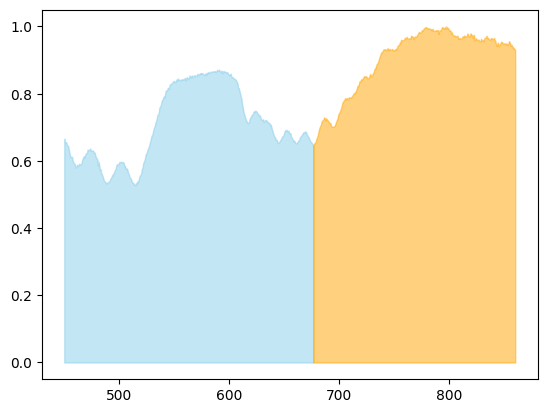

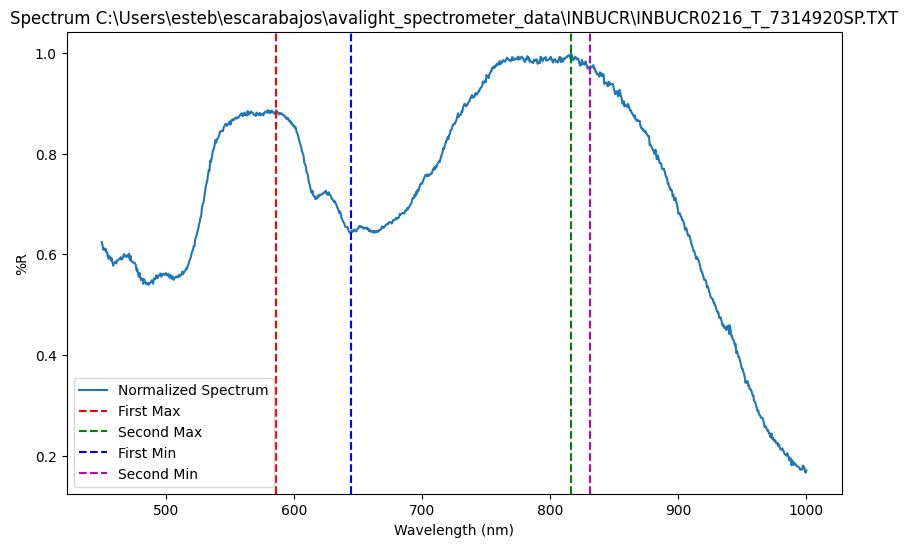

[['CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0173', 'CICIMAUCR0173', 'INBUCR0216', 'INBUCR0216', 'INBUCR0216'], [np.float64(0.970022469242225), nan, np.float64(1.2468440323066452), np.float64(0.7195995425112193), np.float64(1.4298484663481887), nan, np.float64(1.0342092381231824), np.float64(1.1446748669215154)], ['optima', 'optima', 'optima', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea']]


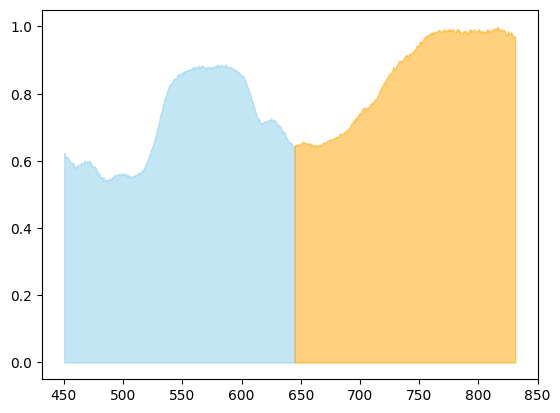

In [10]:
gamma_area_under_curve_first_min_cut_data = feature_and_label_extractor(Metric = Gamma_Area_Under_Curve_First_Min_Cut, 
                                                          config_file = metric_config_main_path, 
                                                          spectra =  all_spectra, 
                                                          debug = debug)

print(gamma_area_under_curve_first_min_cut_data)

In [11]:
gamma_vector_relative_reflectance_data = feature_and_label_extractor(Metric = Gamma_Vector_Relative_Reflectance, 
                                                          config_file = metric_config_main_path, 
                                                          spectra =  all_spectra, 
                                                          debug = debug)


print(gamma_vector_relative_reflectance_data)


[['CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0173', 'CICIMAUCR0173', 'INBUCR0216', 'INBUCR0216', 'INBUCR0216'], [array([1.        , 1.17019856]), array([1.        , 1.16180264]), array([1.       , 1.2643822]), array([1.        , 1.04313115]), array([1.        , 1.21744312]), array([1.        , 1.17753205]), array([1.        , 1.14713049]), array([1.        , 1.12835488])], ['optima', 'optima', 'optima', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea']]


In [12]:
def pad_list(lst, filler=0):
    metrics = lst[1]
    
    for metric in metrics:
        #print(metric)
        
        #max_length = max([len(list) for list in metrics])
        max_length = max(array.shape[-1] for array in metrics)
        #print(max_length)
        
        padded_list = []
        padded_sublist = []
        for element in metrics:
            #get each element
            padded_sublist = element
            #get dimensions
            dimension = padded_sublist.shape
            non_zero_elements = dimension[-1]
            #print(f"{padded_sublist=}")
            #print(f"{dimension=}")
            #create a filler vector with the missing zeroes to reach max 
            if len(dimension) == 2 :
                filler = [[0]* (max_length - non_zero_elements) ]  #add as many vertical zeroes according to the dimension
                filling = filler * dimension[0]
                #print(f"{filler=}")
            else:
                filler = [0]
                filling = filler * dimension[0]
            
            #print(f"{filling=}")
            #concat them if necessary
            if (max_length-non_zero_elements) != 0:
                padded_sublist = np.concatenate(( padded_sublist, filling), axis = len(dimension)-1)
            #add them to the final list
            #print(f"{padded_sublist=}")
            padded_list.append(padded_sublist)
            
    final_list = [lst[0], (padded_list), lst[2]]
    return final_list

pad_list(gamma_vector_relative_reflectance_data)

[['CICIMAUCR0044',
  'CICIMAUCR0044',
  'CICIMAUCR0044',
  'CICIMAUCR0173',
  'CICIMAUCR0173',
  'INBUCR0216',
  'INBUCR0216',
  'INBUCR0216'],
 [array([1.        , 1.17019856]),
  array([1.        , 1.16180264]),
  array([1.       , 1.2643822]),
  array([1.        , 1.04313115]),
  array([1.        , 1.21744312]),
  array([1.        , 1.17753205]),
  array([1.        , 1.14713049]),
  array([1.        , 1.12835488])],
 ['optima',
  'optima',
  'optima',
  'chrysargyrea',
  'chrysargyrea',
  'chrysargyrea',
  'chrysargyrea',
  'chrysargyrea']]

In [13]:
wavelength_vector_data = feature_and_label_extractor(Metric = Wavelength_Vector, 
                                                          config_file = metric_config_main_path, 
                                                          spectra =  all_spectra, 
                                                          debug = debug)


#print(wavelength_vector_data)

data = pad_list(wavelength_vector_data)
print(data)

[['CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0044', 'CICIMAUCR0173', 'CICIMAUCR0173', 'INBUCR0216', 'INBUCR0216', 'INBUCR0216'], [array([590.24, 801.02]), array([592.56, 812.35]), array([592.56, 823.09]), array([568.12, 829.31]), array([580.93, 820.83]), array([601.28, 795.35]), array([590.82, 796.48]), array([586.17, 816.31])], ['optima', 'optima', 'optima', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea']]


Filtering wavelengths


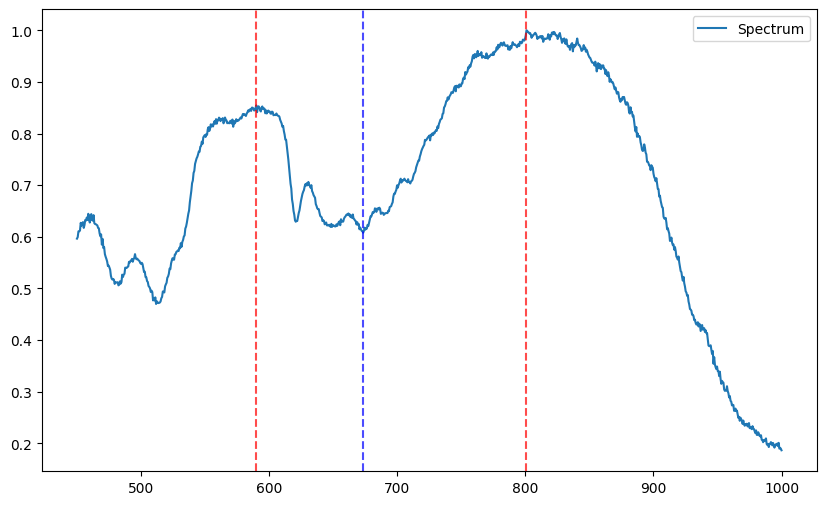

Filtering wavelengths


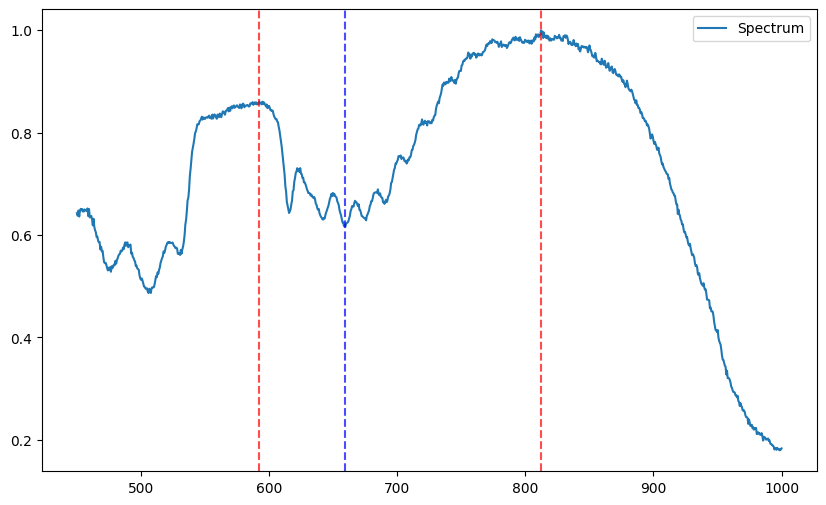

Filtering wavelengths


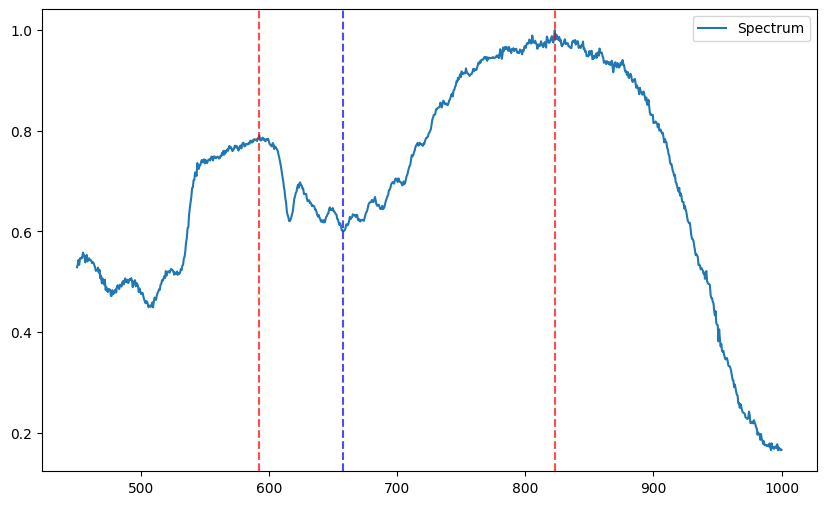

Filtering wavelengths


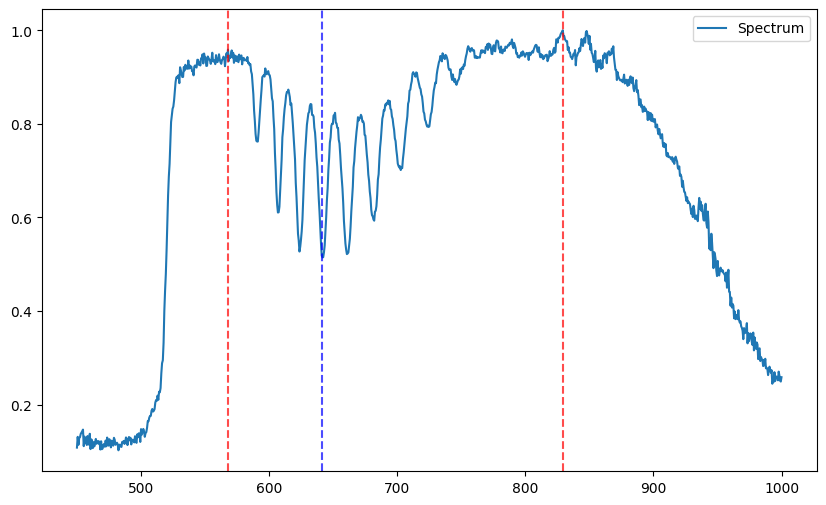

Filtering wavelengths


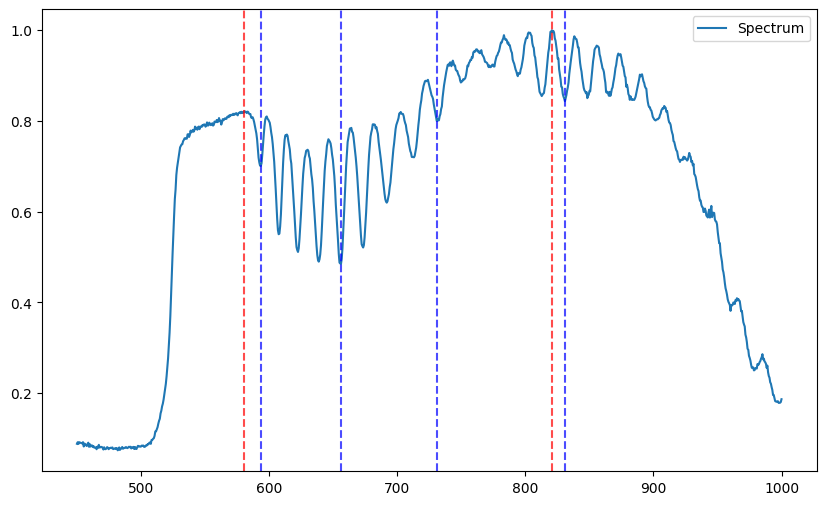

Filtering wavelengths


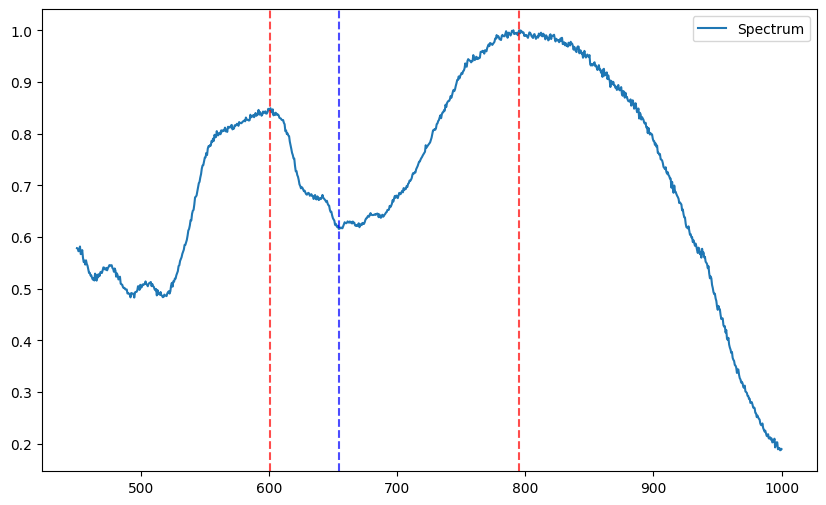

Filtering wavelengths


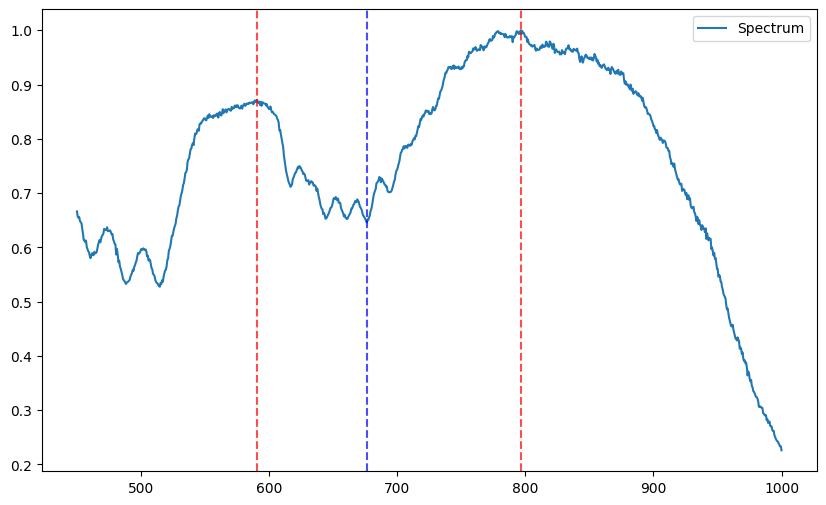

Filtering wavelengths


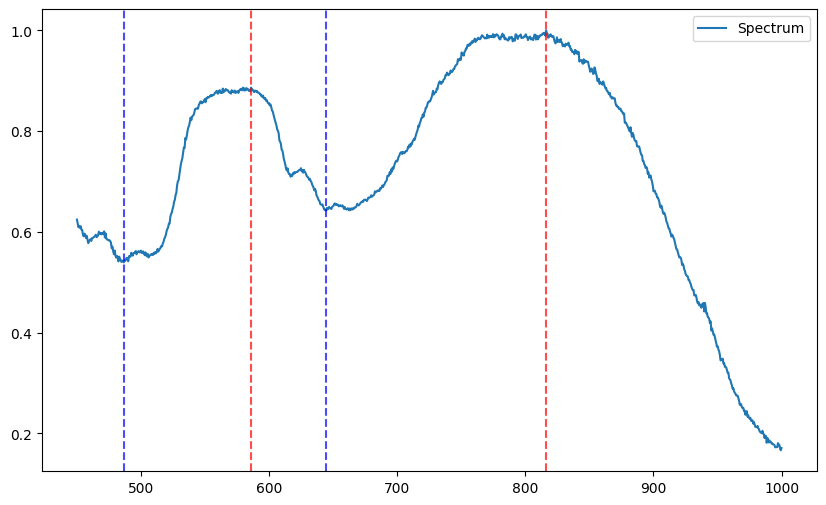

[['CICIMAUCR0044',
  'CICIMAUCR0044',
  'CICIMAUCR0044',
  'CICIMAUCR0173',
  'CICIMAUCR0173',
  'INBUCR0216',
  'INBUCR0216',
  'INBUCR0216'],
 [array([[673.57   , 590.24   , 801.02   ,   0.     ,   0.     ,   0.     ],
         [ 13.81237,  19.41638,  22.72102,   0.     ,   0.     ,   0.     ]]),
  array([[659.74   , 592.56   , 812.35   ,   0.     ,   0.     ,   0.     ],
         [ 17.01231,  23.73583,  27.57635,   0.     ,   0.     ,   0.     ]]),
  array([[658.01   , 592.56   , 823.09   ,   0.     ,   0.     ,   0.     ],
         [ 12.17869,  16.03493,  20.27428,   0.     ,   0.     ,   0.     ]]),
  array([[641.84   , 568.12   , 829.31   ,   0.     ,   0.     ,   0.     ],
         [  3.3745 ,   6.28548,   6.55658,   0.     ,   0.     ,   0.     ]]),
  array([[593.72   , 656.28   , 731.55   , 831.     , 580.93   , 820.83   ],
         [ 27.15362,  18.77654,  31.00563,  32.68738,  31.82446,  38.74447]]),
  array([[654.54   , 601.28   , 795.35   ,   0.     ,   0.     ,   0.     ],

In [14]:
critical_points_data = feature_and_label_extractor(Metric = Critical_Points, 
                                                          config_file = metric_config_main_path, 
                                                          spectra =  all_spectra, 
                                                          debug = debug)


#print(critical_points_data)
pad_list(critical_points_data, filler = np.array([0,0]).T)


## Aggregate data for each metric
### Boxplots and histograms for each metric, classified by species

In [15]:
get_aggregated_data(Gamma_Arbitrary_Limits_Silver,all_spectra)

C:\Users\esteb\escarabajos\libraries\feature_engineering.py:118: UserWarning: No valid metric values computed. Returning empty DataFrame.
  warnings.warn("No valid metric values computed. Returning empty DataFrame.", UserWarning)


""


In [16]:
get_aggregated_data(Gamma_First_Two_Peaks,all_spectra)

C:\Users\esteb\escarabajos\libraries\feature_engineering.py:118: UserWarning: No valid metric values computed. Returning empty DataFrame.
  warnings.warn("No valid metric values computed. Returning empty DataFrame.", UserWarning)


""


In [17]:
get_aggregated_data(Gamma_Area_Under_Curve_Naive,all_spectra)

C:\Users\esteb\escarabajos\libraries\feature_engineering.py:118: UserWarning: No valid metric values computed. Returning empty DataFrame.
  warnings.warn("No valid metric values computed. Returning empty DataFrame.", UserWarning)


""


In [18]:
get_aggregated_data(Gamma_Area_Under_Curve_First_Min_Cut,all_spectra)

C:\Users\esteb\escarabajos\libraries\feature_engineering.py:118: UserWarning: No valid metric values computed. Returning empty DataFrame.
  warnings.warn("No valid metric values computed. Returning empty DataFrame.", UserWarning)


""


## Boxplots

UV VIS MIN 450.0 UV VIS MAX: 800.0
POINT: 799.88 22.34607
ir_min_wavelength 450.0 ir_max_wavelength: 800.0
POINT: 801.02 22.72102
Filtering wavelengths


C:\Users\esteb\escarabajos\libraries\metrics.py:106: UserWarning: Config missing [Gamma_Arbitrary_Limits] section, using defaults.
  warnings.warn(f"Config missing [{self.name}] section, using defaults.", UserWarning)


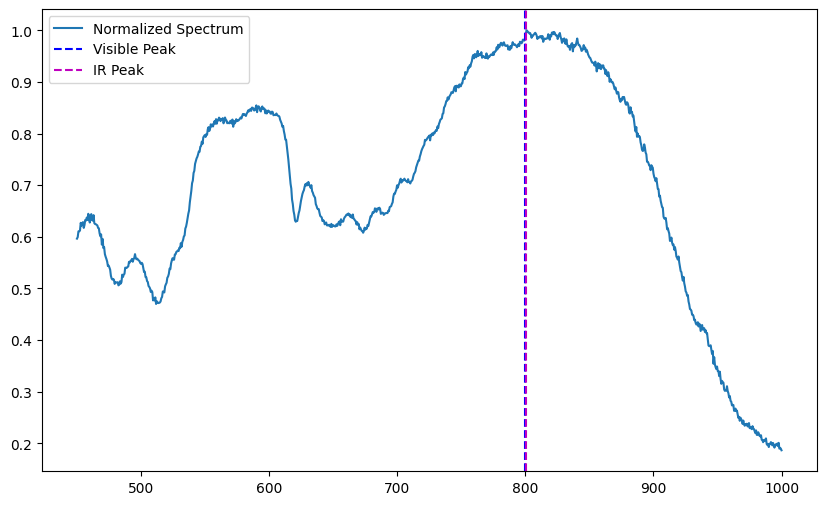

C:\Users\esteb\escarabajos\libraries\metrics.py:106: UserWarning: Config missing [Gamma_Arbitrary_Limits] section, using defaults.
  warnings.warn(f"Config missing [{self.name}] section, using defaults.", UserWarning)


UV VIS MIN 450.0 UV VIS MAX: 800.0
POINT: 792.51 27.2267
ir_min_wavelength 450.0 ir_max_wavelength: 800.0
POINT: 812.35 27.57635
Filtering wavelengths


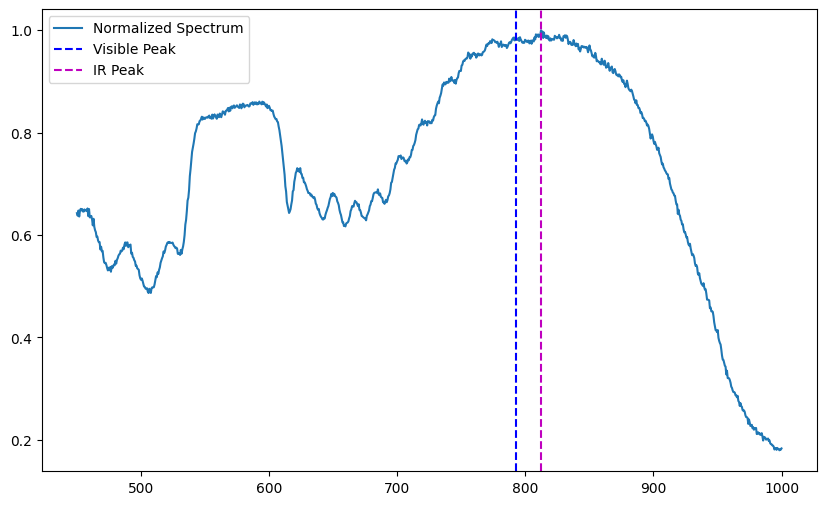

UV VIS MIN 450.0 UV VIS MAX: 800.0
POINT: 799.88 19.63575
ir_min_wavelength 450.0 ir_max_wavelength: 800.0
POINT: 823.09 20.27428
Filtering wavelengths


C:\Users\esteb\escarabajos\libraries\metrics.py:106: UserWarning: Config missing [Gamma_Arbitrary_Limits] section, using defaults.
  warnings.warn(f"Config missing [{self.name}] section, using defaults.", UserWarning)


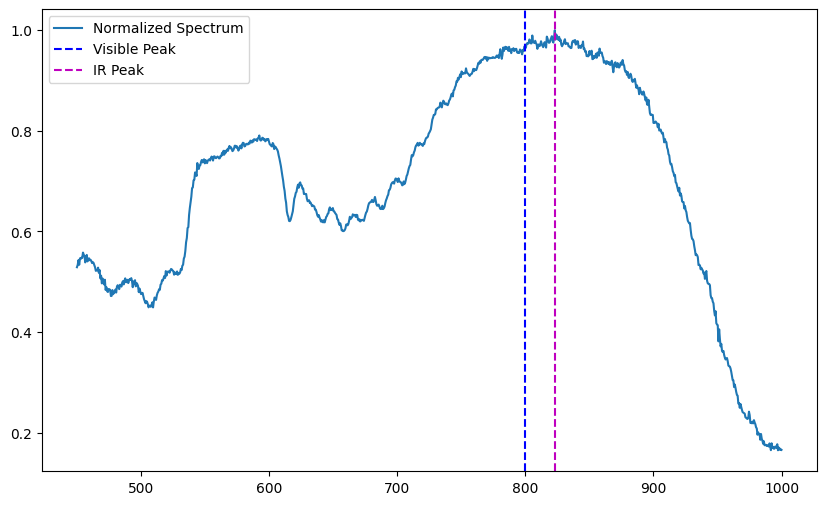

C:\Users\esteb\escarabajos\libraries\metrics.py:106: UserWarning: Config missing [Gamma_Arbitrary_Limits] section, using defaults.
  warnings.warn(f"Config missing [{self.name}] section, using defaults.", UserWarning)


UV VIS MIN 450.0 UV VIS MAX: 800.0
POINT: 789.67 6.42882
ir_min_wavelength 450.0 ir_max_wavelength: 800.0
POINT: 829.31 6.55658
Filtering wavelengths


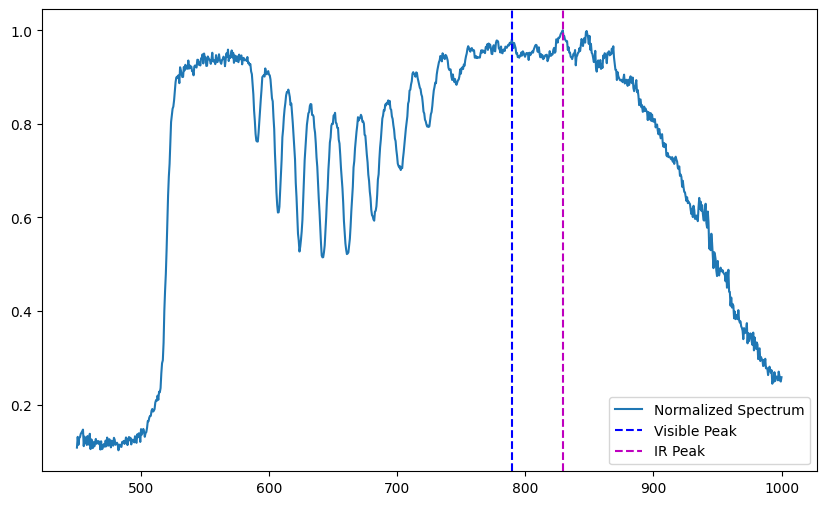

UV VIS MIN 450.0 UV VIS MAX: 800.0
POINT: 783.42 38.32763
ir_min_wavelength 450.0 ir_max_wavelength: 800.0
POINT: 820.83 38.74447
Filtering wavelengths


C:\Users\esteb\escarabajos\libraries\metrics.py:106: UserWarning: Config missing [Gamma_Arbitrary_Limits] section, using defaults.
  warnings.warn(f"Config missing [{self.name}] section, using defaults.", UserWarning)


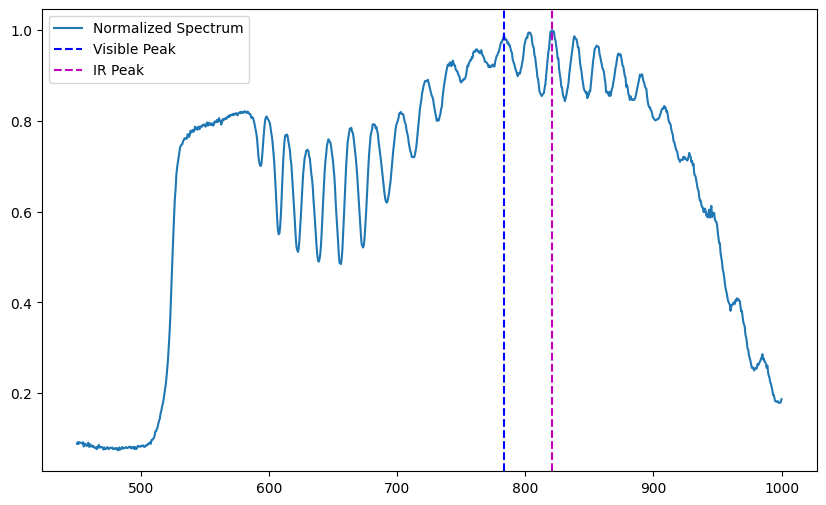

C:\Users\esteb\escarabajos\libraries\metrics.py:106: UserWarning: Config missing [Gamma_Arbitrary_Limits] section, using defaults.
  warnings.warn(f"Config missing [{self.name}] section, using defaults.", UserWarning)


UV VIS MIN 450.0 UV VIS MAX: 800.0
POINT: 795.35 27.26725
ir_min_wavelength 450.0 ir_max_wavelength: 800.0
POINT: 803.28 27.15509
Filtering wavelengths


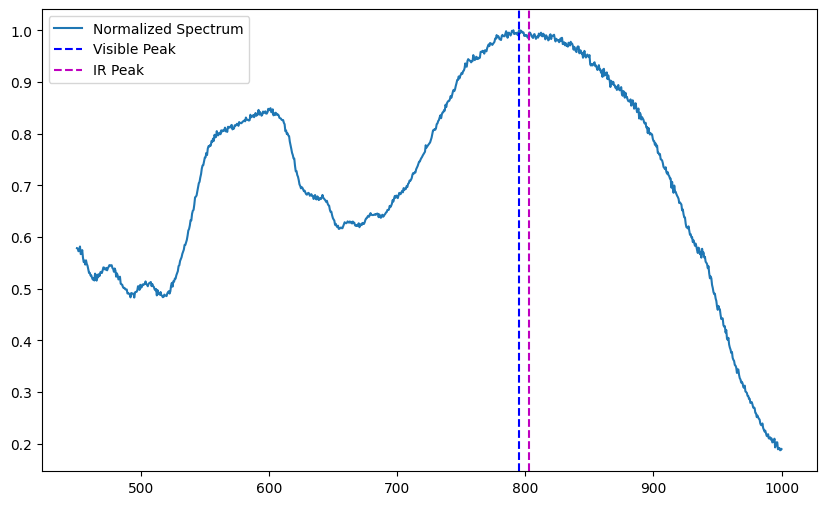

UV VIS MIN 450.0 UV VIS MAX: 800.0
POINT: 796.48 44.30959
ir_min_wavelength 450.0 ir_max_wavelength: 800.0
POINT: 800.45 43.77621
Filtering wavelengths


C:\Users\esteb\escarabajos\libraries\metrics.py:106: UserWarning: Config missing [Gamma_Arbitrary_Limits] section, using defaults.
  warnings.warn(f"Config missing [{self.name}] section, using defaults.", UserWarning)


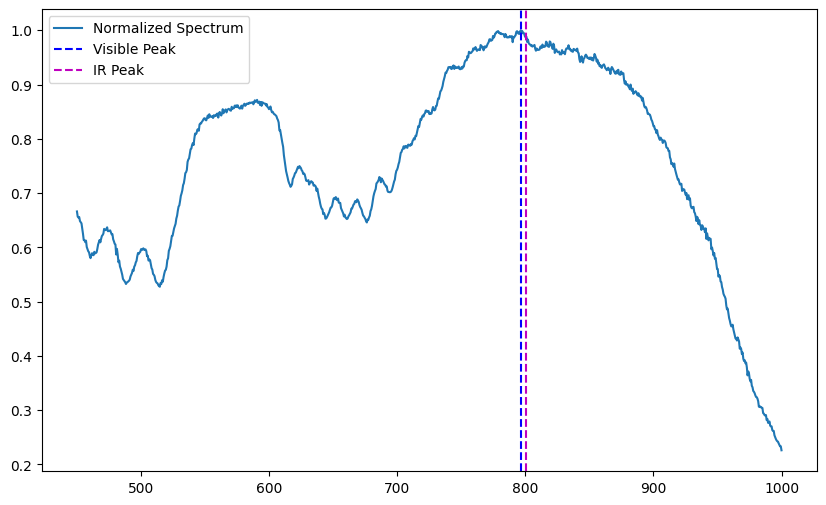

C:\Users\esteb\escarabajos\libraries\metrics.py:106: UserWarning: Config missing [Gamma_Arbitrary_Limits] section, using defaults.
  warnings.warn(f"Config missing [{self.name}] section, using defaults.", UserWarning)


UV VIS MIN 450.0 UV VIS MAX: 800.0
POINT: 782.29 43.9767
ir_min_wavelength 450.0 ir_max_wavelength: 800.0
POINT: 816.31 44.27695
Filtering wavelengths


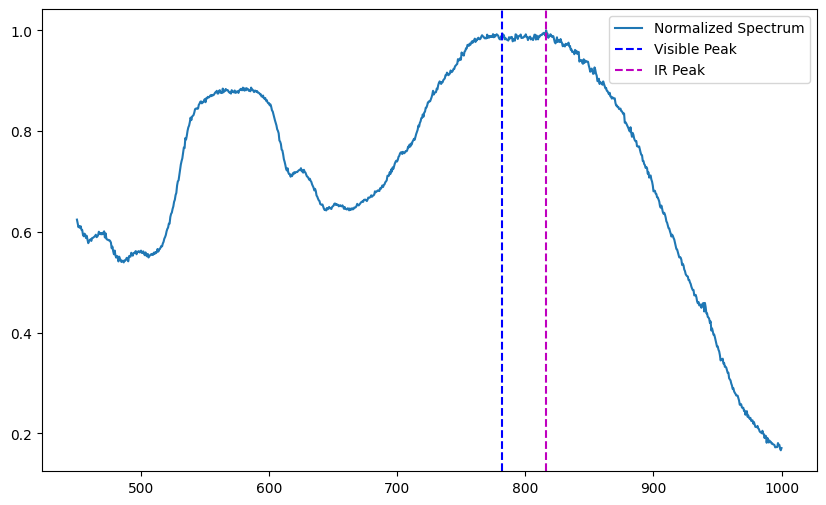

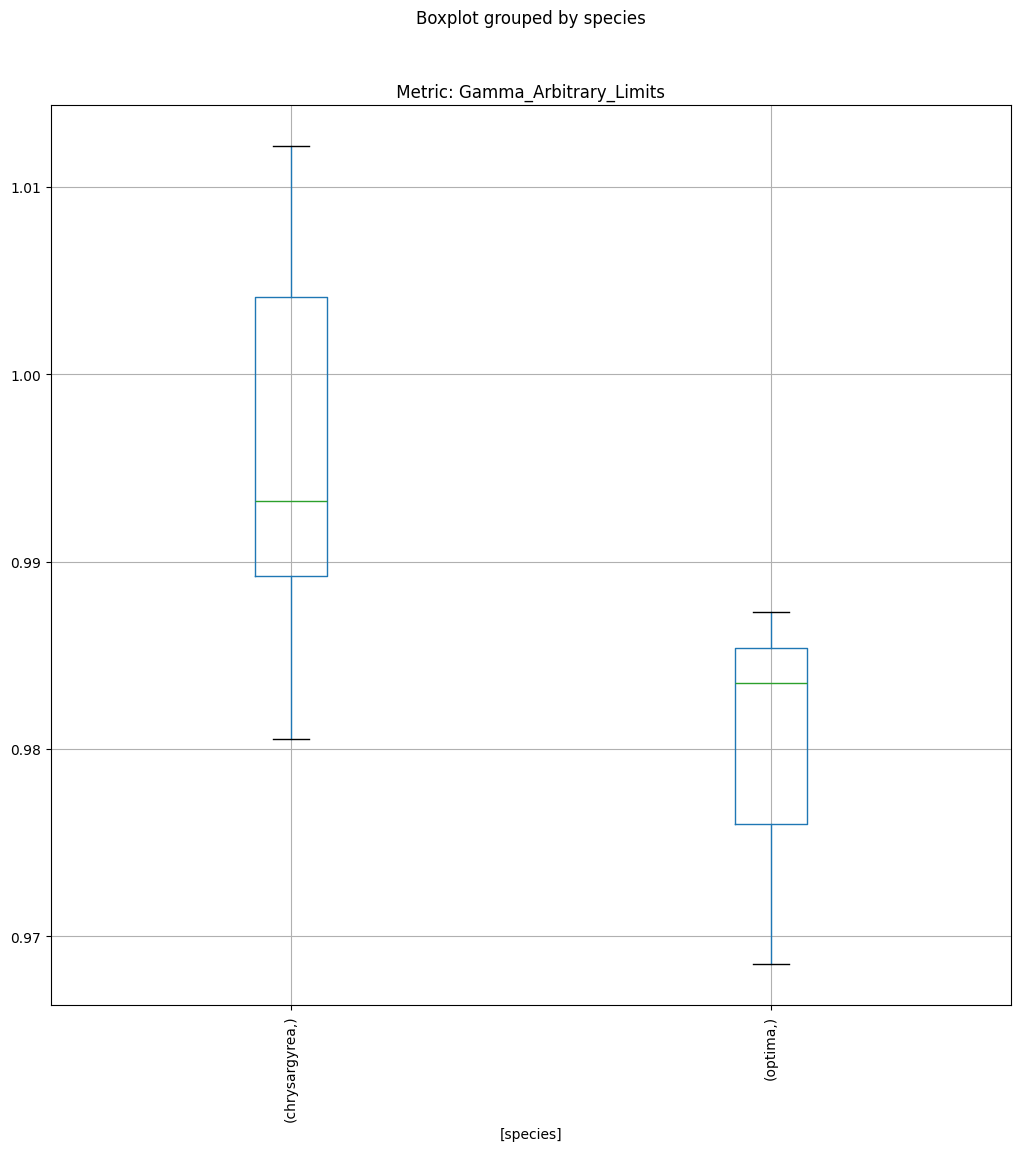

In [21]:
Metric_Testbench(Gamma_Arbitrary_Limits_Silver, spectra = all_spectra, config_file = config_file_main_path)

C:\Users\esteb\escarabajos\libraries\metrics.py:58: UserWarning: Config missing [Gamma_First_Two_Peaks] section, using defaults.
  warnings.warn(f"Config missing [{self.name}] section, using defaults.", UserWarning)


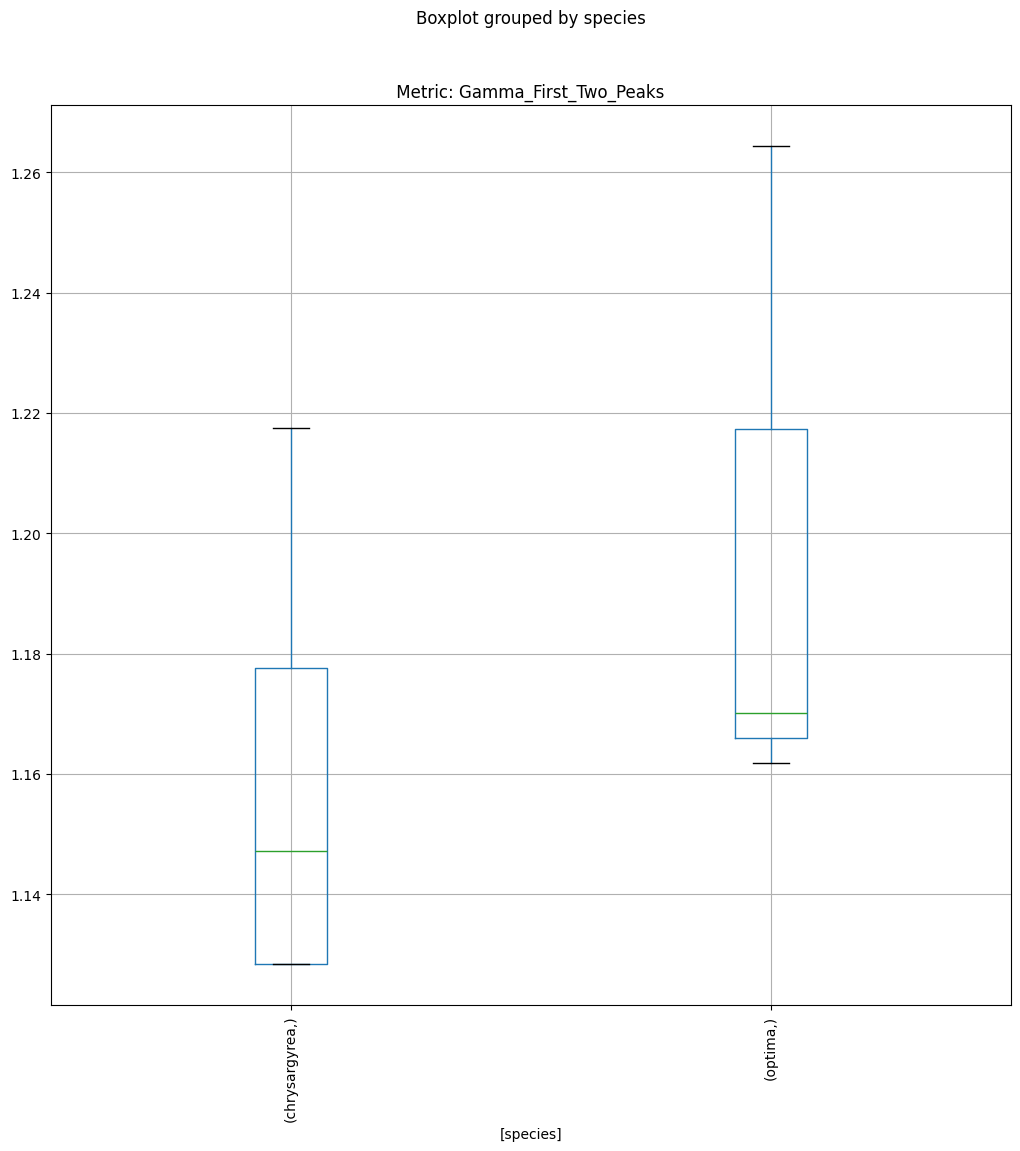

In [22]:
Metric_Testbench(Gamma_First_Two_Peaks, spectra = all_spectra, config_file = config_file_main_path)

Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'


C:\Users\esteb\escarabajos\libraries\metrics.py:242: UserWarning: Config missing [Gamma_Area_Under_Curve_Naive] section, using defaults.
  warnings.warn(f"Config missing [{self.name}] section, using defaults.", UserWarning)


ValueError: not enough values to unpack (expected 2, got 0)

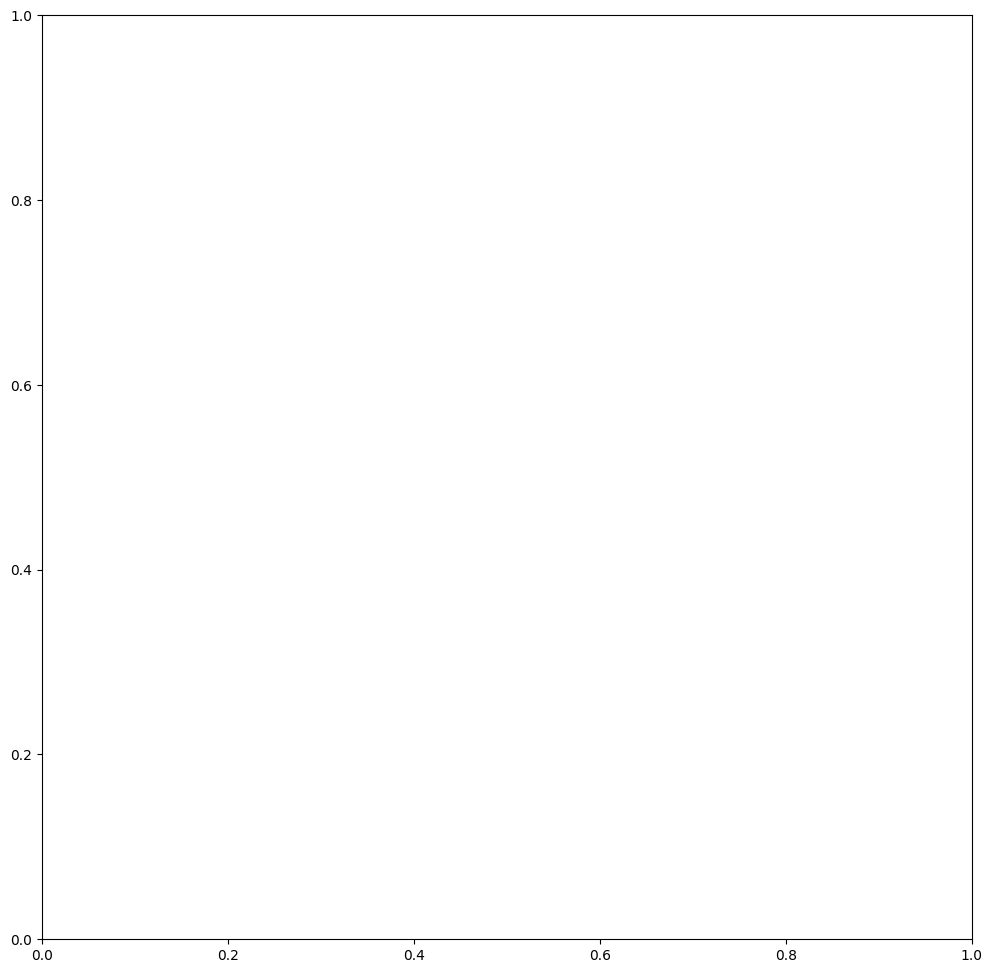

In [23]:
Metric_Testbench(Gamma_Area_Under_Curve_Naive, spectra = all_spectra, config_file = config_file_main_path)

Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'
Available sections: []
'dict' object has no attribute 'getfloat'


C:\Users\esteb\escarabajos\libraries\metrics.py:302: UserWarning: Config missing [Gamma_Area_Under_Curve_First_Min_Cut] section, using defaults.
  warnings.warn(f"Config missing [{self.name}] section, using defaults.", UserWarning)


ValueError: not enough values to unpack (expected 2, got 0)

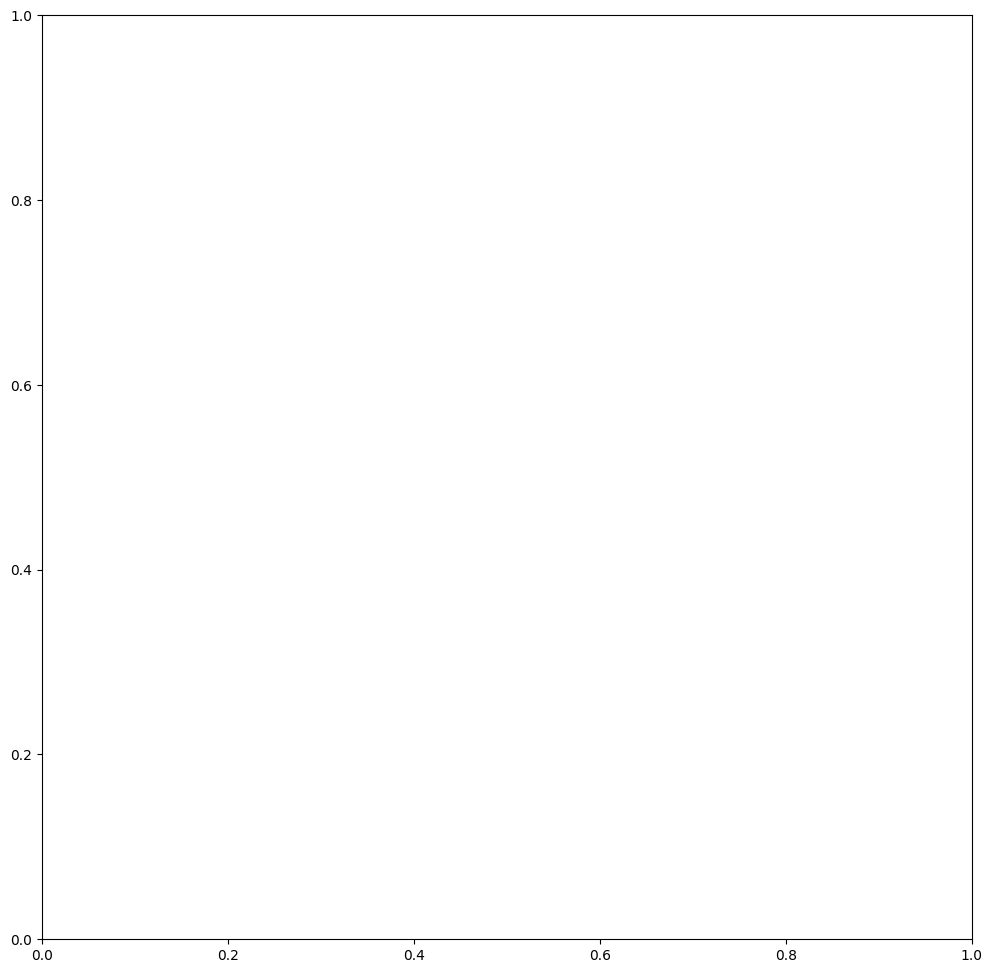

In [24]:
Metric_Testbench(Gamma_Area_Under_Curve_First_Min_Cut, spectra = all_spectra, config_file = config_file_main_path)

## Classification

In [25]:
def transpose_list(lst):
    return list(zip(*lst))

In [29]:
def get_nth_feature(data, n):
    feature_vector = [data[0], [x[n] for x in data[1]] , data[2]] 
    return feature_vector
def scatter_plot_2_variables(df_1, df_2):

    joint_df = pd.merge(df_1, df_2, on=["code", "species"], how="inner")
    column_list = joint_df.columns.tolist()
    print(column_list)
    column_list = [x for x in column_list if x not in ["code", "species"] ]
    print(column_list)
    plt.figure()
    plt.grid()
    sns.scatterplot(joint_df, x=column_list[0], y =column_list[1], hue="species")

    #save image
    path= os.path.join(report_location, "report_images", f"{current_date}", "species classifier")
    create_path_if_not_exists(path)
    filename = os.path.join(path, f"{Metric.get_name()} "+ collection_names + f"-{next(image_counter)}" +".png") 
    plt.savefig(filename)

    plt.show()


## 

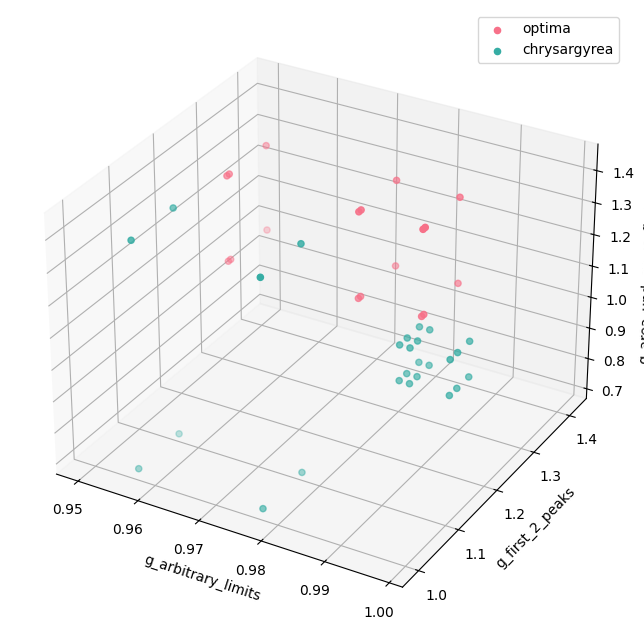

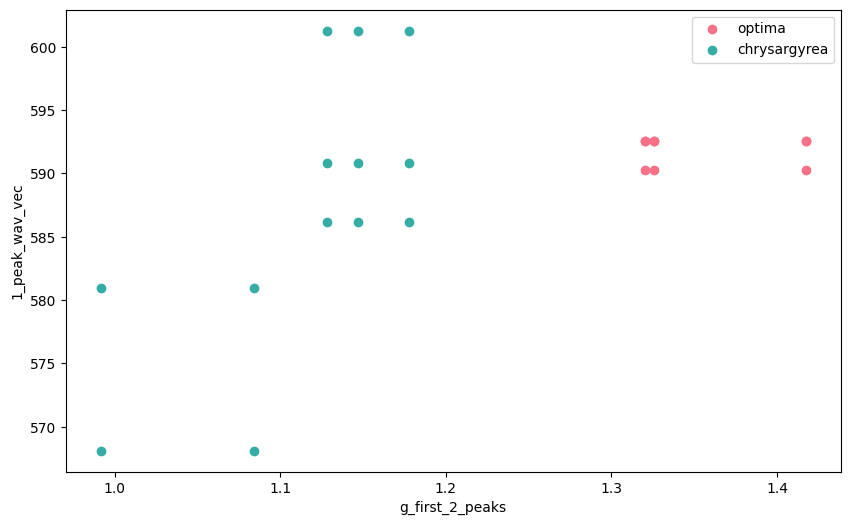

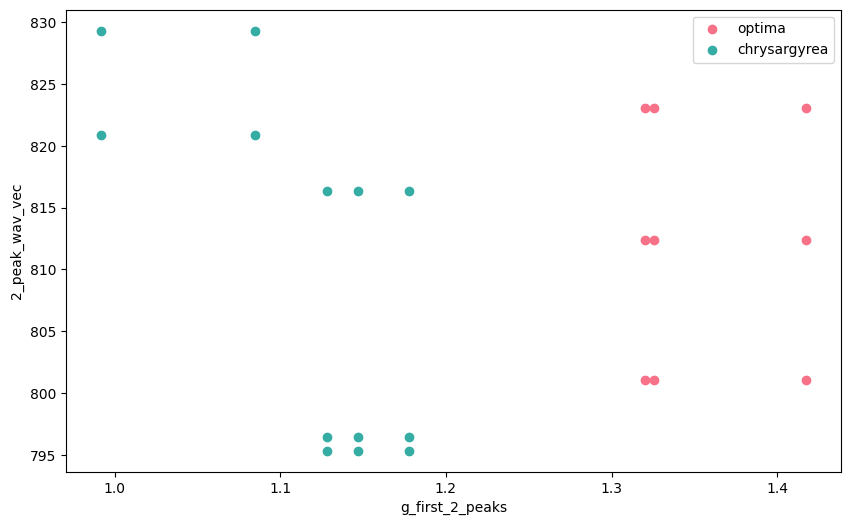

IndexError: index 2 is out of bounds for axis 0 with size 2

In [32]:
import seaborn as sns

#Definicion de las variables
gal_df = pd.DataFrame(transpose_list(gamma_arbitrary_limits_data), columns =["code", "g_arbitrary_limits", "species"]) 
gftp_df = pd.DataFrame(transpose_list(gamma_first_two_peaks_data), columns =["code", "g_first_2_peaks", "species"])
gaucfmc_df = pd.DataFrame(transpose_list(gamma_area_under_curve_first_min_cut_data), columns =["code", "g_area_und_curve_first_min", "species"]) 
gauc_df = pd.DataFrame(transpose_list(gamma_area_under_curve_data), columns =["code", "g_area_und_curve", "species"])

scatter_plot_3_variables(gal_df, gftp_df, gaucfmc_df, collection_names = ["CICIMAUCR", "INBUCR"] , report_location= report_location, image_counter=image_counter, target_species=None)


for n in range(0,7):
    n_peak_wavelength_vector_data = get_nth_feature(data, n)
    
    pnwvd_df = pd.DataFrame(transpose_list(n_peak_wavelength_vector_data), columns =["code", f"{n+1}_peak_wav_vec", "species"])
    
    scatter_plot_2_variables(gftp_df, pnwvd_df , collection_names = ["CICIMAUCR", "INBUCR"]  , report_location= report_location, image_counter=image_counter,)

    
scatter_plot_2_variables(gal_df, gauc_df , collection_names = ["CICIMAUCR", "INBUCR"]  , report_location= report_location, image_counter=image_counter,)
#scatter_plot_2_variables(gal_df, gaucfmc_df)
#scatter_plot_2_variables(gftp_df, gauc_df)
#scatter_plot_2_variables(gftp_df, gaucfmc_df)
#scatter_plot_2_variables(gftp_df, p1wvd_df)
#scatter_plot_2_variables(gftp_df, p2wvd_df)
#create scatter plot
#gamma_area_under_curve_data

## Prediction one variable

In [33]:
import sys

print(sys.version_info)

sys.version_info(major=3, minor=12, micro=7, releaselevel='final', serial=0)


In [34]:
#@title Import relevant modules

from tensorflow.keras import layers


# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

In [35]:
def replace_strings(lst):
    mapping = {"kalinini": 0, "resplendens": 1, "cupreomarginata": 2}
    return [mapping.get(item, item) for item in lst]

In [36]:
#gal_df 
#gftp_df 
#gaucfmc_df 
#gauc_df

def get_x_y(df):
    columns = df.columns
    x_column_name = [x for x in columns if x not in ["code", "species"]]
    x = df[x_column_name].values
    y = df["species"].values
    y_p = np.array(replace_strings(y))
    x = np.array(x)
    return x, y_p
    
x,y_p = get_x_y(gaucfmc_df)

y_p

array(['optima', 'optima', 'optima', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea', 'chrysargyrea'], dtype='<U12')

In [37]:
import random

def permute_lists(list1, list2):
    # Generate a random permutation index
    permutation_index = list(range(len(list1)))
    random.shuffle(permutation_index)

    # Apply the same permutation to both lists
    permuted_list1 = [list1[i] for i in permutation_index]
    permuted_list2 = [list2[i] for i in permutation_index]

    return permuted_list1, permuted_list2
    
def partition_lists(list1, list2, fraction):
    if fraction >= 1:
        raise ValueError("Fraction must be less than 1")
    if fraction  < 0:
        raise ValueError("Fraction must be more than 0")
        
    num_elements = len(list1)
    num_selected = int(num_elements * fraction)

    # Partition elements based on the fraction
    selected_list1 = list1[:num_selected]
    selected_list2 = list2[:num_selected]
    remaining_list1 = list1[num_selected:]
    remaining_list2 = list2[num_selected:]

    return selected_list1, selected_list2, remaining_list1, remaining_list2

def get_training_and_test_data(features, labels, fraction):
    permutated_features, permuted_labels = permute_lists(features, labels)
    training_features, training_labels, test_features, test_labels = partition_lists(permutated_features, permuted_labels, fraction)
    training_features, training_labels, test_features, test_labels = np.array(training_features),  np.array(training_labels),  np.array(test_features),  np.array(test_labels)
    return training_features, training_labels, test_features, test_labels

x_train, y_train,x_test, y_test  = get_training_and_test_data(x, y_p, 0.5)

In [38]:
print(x_train, y_train)

[[0.97002247]
 [1.03420924]
 [1.14467487]
 [       nan]] ['optima' 'chrysargyrea' 'chrysargyrea' 'optima']


In [39]:

def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [40]:
def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(1,)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)
                      #validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

In [41]:
# The following variables are the hyperparameters.
learning_rate = 0.008
epochs = 150
batch_size = 3
validation_split = 0.3

# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
#epochs, hist = train_model(my_model, x_train, y_train, 
                           #epochs, batch_size, validation_split)
epochs, hist = train_model(my_model, x_train, y_train, 
                           epochs, batch_size)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test, y=y_test, batch_size=batch_size)

C:\Users\esteb\miniconda3\envs\tensorflow\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Invalid dtype: str384

With hiperparameters: 
learning_rate = 0.008
epochs = 150
batch_size = 3
validation_split = 0.3

accuracy:
gal_df_:     0.43
gftp_df:     0.61 
gaucfmc_df:  0.77
gauc_df:     0.27

## Prediction vectorial features

In [42]:
import numpy as np
print(list(gamma_vector_relative_reflectance_data[1]))
gamma_vector_relative_reflectance_data_np = np.array(gamma_vector_relative_reflectance_data[1])
gamma_vector_relative_reflectance_data_np

[array([1.        , 1.17019856]), array([1.        , 1.16180264]), array([1.       , 1.2643822]), array([1.        , 1.04313115]), array([1.        , 1.21744312]), array([1.        , 1.17753205]), array([1.        , 1.14713049]), array([1.        , 1.12835488])]


array([[1.        , 1.17019856],
       [1.        , 1.16180264],
       [1.        , 1.2643822 ],
       [1.        , 1.04313115],
       [1.        , 1.21744312],
       [1.        , 1.17753205],
       [1.        , 1.14713049],
       [1.        , 1.12835488]])

In [43]:
#gvrrd_df = pd.DataFrame(transpose_list(gamma_vector_relative_reflectance_data), columns =["code", "g_arbitrary_limits", "species"])
gvrrd_df = pd.DataFrame(transpose_list(gamma_vector_relative_reflectance_data), columns =["code", "g_arbitrary_limits", "species"])
gvrrd_df


,code,g_arbitrary_limits,species
0,CICIMAUCR0044,"[1.0, 1.1701985643049837]",optima
1,CICIMAUCR0044,"[1.0, 1.16180264182883]",optima
2,CICIMAUCR0044,"[1.0, 1.264382195619189]",optima
3,CICIMAUCR0173,"[1.0, 1.043131153070251]",chrysargyrea
4,CICIMAUCR0173,"[1.0, 1.2174431239367456]",chrysargyrea
5,INBUCR0216,"[1.0, 1.1775320463960735]",chrysargyrea
6,INBUCR0216,"[1.0, 1.1471304903426303]",chrysargyrea
7,INBUCR0216,"[1.0, 1.1283548762533997]",chrysargyrea


In [44]:
def get_x_y(df):
    columns = df.columns
    x_column_name = [x for x in columns if x not in ["code", "species"]]
    x = df[x_column_name].values
    x2 = []
    for element in x:
        xp = str(element).replace("[array(", "").replace(")]", "")
        ev = eval(xp)
        x2.append(ev)
    x2 = np.array(x2)
    
    y = df["species"].values
    y= replace_strings(y)
    y= np.array(y)
    #print(y)
    #print(df.dtypes)
    return x2, y

x,y_p = get_x_y(gvrrd_df)


In [45]:
x_train, y_train,x_test, y_test  = get_training_and_test_data(x, y_p, 0.4)

In [ ]:
x_train[0]


In [ ]:
def create_model_2(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(9,)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=40, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  #model.add(tf.keras.layers.Dense(units=20, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.4))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True,
                      validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 150
batch_size = 1
validation_split = 0.0

# Establish the model's topography.
my_model = create_model_2(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, x_train, y_train, 
                           #epochs, batch_size, validation_split)
#epochs, hist = train_model(my_model, x_train, y_train, 
                           epochs, batch_size)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test, y=y_test, batch_size=batch_size)

#amplitud en IR vs amplitud en el visible
#700 nm
visible horizontal, IR vertical. 
#gamma vertical, amplitud pico IR horizontal 
#y es amplitud en el IR, x es el gamma

## Prediction 2 variables

In [ ]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

#first scenario gamma_first_two_peaks and gamma_area_under_curve_first_minimum
#Definicion de las variables
gal_df 
gftp_df 
gaucfmc_df 
gauc_df 


In [ ]:
#define the dataframe

complete_df = pd.merge(gal_df, gftp_df, on=["species","code"], how="inner")
complete_df = pd.merge(complete_df, gaucfmc_df, on=["species","code"], how="inner")
complete_df = pd.merge(complete_df, gauc_df, on=["species","code"], how="inner")
complete_df.drop(columns=['code'], inplace=True)

fraction = 0.8

def substitute_species(df):
    df.loc[df["species"] == "kalinini"] = -100.0
    df.loc[df["species"] == "resplendens"] = 0.0
    df.loc[df["species"] == "cupreomarginata"] = 100.0
    return df 

complete_df = substitute_species(complete_df)


def split_train_test(df, fraction):
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=1, random_state=0)
    
    # Calculate the number of rows for the training set
    train_size = int(fraction * len(df))
    
    # Split the DataFrame
    train_df = shuffled_df[:train_size]
    test_df = shuffled_df[train_size:]
    
    return train_df, test_df
    
train_df, test_df =split_train_test(complete_df, fraction)
#print(complete_df)
#print(train_df)
#print(test_df)

In [ ]:
# Keras Input tensors of float values.
inputs = {
    'g_arbitrary_limits':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='g_arbitrary_limits '),
    'g_first_2_peaks':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='g_first_2_peaks'),
    'g_area_und_curve_first_min':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='g_area_und_curve_first_min'),
    'g_area_und_curve':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='g_area_und_curve')
}

# Create a Normalization layer to normalize the median_income data.
g_area_und_curve_first_min = tf.keras.layers.Normalization(
    name='normalization_g_area_und_curve_first_min',
    axis=None)
g_area_und_curve_first_min.adapt(train_df['g_area_und_curve_first_min'])
g_area_und_curve_first_min = g_area_und_curve_first_min(inputs.get('g_area_und_curve_first_min'))

# Create a Normalization layer to normalize the population data.
g_area_und_curve = tf.keras.layers.Normalization(
    name='normalization_g_area_und_curve',
    axis=None)
g_area_und_curve.adapt(train_df['g_area_und_curve_first_min'])
g_area_und_curve = g_area_und_curve(inputs.get('g_area_und_curve'))


# Create a Normalization layer to normalize the latitude data.
g_arbitrary_limits = tf.keras.layers.Normalization(
    name='normalization_g_arbitrary_limits',
    axis=None)
g_arbitrary_limits.adapt(train_df['g_arbitrary_limits'])
g_arbitrary_limits = g_arbitrary_limits(inputs.get('g_arbitrary_limits'))


# Create a Normalization layer to normalize the longitude data.
g_first_2_peaks = tf.keras.layers.Normalization(
    name='normalization_g_first_2_peaks',
    axis=None)
g_first_2_peaks.adapt(train_df['g_first_2_peaks'])
g_first_2_peaks = g_first_2_peaks(inputs.get('g_first_2_peaks'))

# Concatenate our inputs into a single tensor.
preprocessing_layers = tf.keras.layers.Concatenate()(
    [g_arbitrary_limits, g_first_2_peaks, g_area_und_curve, g_area_und_curve_first_min])

print("Preprocessing layers defined.")

In [ ]:


def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  # mse_training is a pandas Series, so convert it to a list first.
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

print("Defined the plot_the_loss_curve function.")

In [ ]:
from tensorflow import Tensor

In [ ]:
#@title Define functions to create and train a linear regression model
def create_model(my_inputs, my_outputs, my_learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  print(features)
 
  #Considering y variable holds numpy array
  train_features_tensor = tf.convert_to_tensor(np.array(features.pop(label_name)), dtype=tf.int64) 
  label = train_median_house_value_normalized(train_features_tensor)

  for element in features:
      features[element] =  tf.convert_to_tensor(np.array(features[element]), dtype=tf.int64) 
      
  print(f"{label=}")
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

print("Defined the create_model and train_model functions.")

In [ ]:
train_df.fillna(value='', inplace=True)
test_df.fillna(value='', inplace=True)

x_train = np.asarray(train_df['species']).astype('float32')
x_test = np.asarray(test_df['species']).astype('float32')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#@title Define normalized label columns
# Create Normalization layers to normalize the median_house_value data.
# Because median_house_value is our label (i.e., the target value we're
# predicting), these layers won't be added to our model.
train_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
train_median_house_value_normalized.adapt(x_train)
print(train_median_house_value_normalized)

test_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
test_median_house_value_normalized.adapt(x_test)
print(test_median_house_value_normalized)

In [ ]:
#@title Define linear regression model outputs
def get_outputs_linear_regression():
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "species"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size,
                          label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_df.items()}

test_features_tensor = tf.convert_to_tensor(np.array(test_features.pop(label_name)), dtype=tf.int64) 

test_label = test_median_house_value_normalized(test_features_tensor) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

In [ ]:
def get_outputs_dnn():
  # Create a Dense layer with 20 nodes.
  dense_output = tf.keras.layers.Dense(units=20,
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
  # Create a Dense layer with 12 nodes.
  dense_output = tf.keras.layers.Dense(units=12,
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(dense_output)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }

  return outputs

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "species"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_df, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}

train_features_tensor = tf.convert_to_tensor(np.array(test_features.pop(label_name)), dtype=tf.int64) 

test_label = test_median_house_value_normalized(train_features_tensor) # isolate the label

print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

In [ ]:
#Save model 

# Define the file path where you want to save your model
model_file_path = 'trained_model.h5'

# Save the model
my_model.save(model_file_path)

print("Model saved successfully at:", model_file_path)

In [ ]:
# Load the saved model
model_file_path = 'trained_model.h5'
loaded_model = tf.keras.models.load_model(model_file_path)

#load prediction data
#prediction_spectra

prediction_gamma_arbitrary_limits_data = feature_and_label_extractor(Gamma_Arbitrary_Limits_Silver, prediction_spectra)
prediction_gamma_first_two_peaks_data = feature_and_label_extractor(Gamma_First_Two_Peaks, prediction_spectra)
prediction_gamma_area_under_curve_data = feature_and_label_extractor(Gamma_Area_Under_Curve_Naive, prediction_spectra)
prediction_gamma_area_under_curve_first_min_cut_data = feature_and_label_extractor(Gamma_Area_Under_Curve_First_Min_Cut, prediction_spectra)

prediction_gamma_vector_relative_reflectance_data = feature_and_label_extractor(Gamma_Vector_Relative_Reflectance, prediction_spectra)
prediction_critical_points_data = feature_and_label_extractor(Critical_Points, prediction_spectra)

#Definicion de las variables
pred_gal_df = pd.DataFrame(transpose_list(prediction_gamma_arbitrary_limits_data), columns =["code", "g_arbitrary_limits", "real_species"]) 
pred_gftp_df = pd.DataFrame(transpose_list(prediction_gamma_first_two_peaks_data), columns =["code", "g_first_2_peaks", "real_species"])
pred_gaucfmc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_first_min_cut_data), columns =["code", "g_area_und_curve_first_min", "real_species"]) 
pred_gauc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_data), columns =["code", "g_area_und_curve", "real_species"])


#drop species

drop_pred_gal_df = pred_gal_df.copy()

drop_pred_gal_df.drop(columns=[ "real_species"], inplace=True)


drop_pred_gftp_df = pred_gftp_df.copy()
drop_pred_gftp_df.drop(columns=[ "real_species"], inplace=True)


drop_pred_gauc_df= pred_gauc_df.copy()
drop_pred_gauc_df.drop(columns=[ "real_species"], inplace=True)

drop_pred_gaucfmc_df=pred_gaucfmc_df.copy()
drop_pred_gaucfmc_df.drop(columns=[ "real_species"], inplace=True)


#merge on code
pred_complete_df = pd.merge(drop_pred_gal_df, drop_pred_gftp_df, on=["code"], how="inner")
print(pred_complete_df)
pred_complete_df = pd.merge(pred_complete_df, drop_pred_gauc_df, on=["code"], how="inner")
pred_complete_df = pd.merge(pred_complete_df, drop_pred_gaucfmc_df, on=["code"], how="inner")

pred_complete_df.drop(columns=[ "code"], inplace=True)
pred_complete_df


In [ ]:

# Assuming `features_to_predict` contains the features you want to use for prediction
prediction_features = {name:np.array(value) for name, value in pred_complete_df.items()}

#convert prediction_features to tensor
for element in prediction_features:
    prediction_features[element] = tf.convert_to_tensor(np.array(prediction_features[element]), dtype=tf.int64) 


# Predict using the loaded model
predictions = loaded_model.predict(prediction_features)

# Print the predictions
print(predictions)

In [ ]:
# Calculate the mean and standard deviation used for normalization
original_mean = train_df[label_name].mean()
original_stddev = train_df[label_name].std()
print(predictions['dense_output'])
predictions_unnormalized = (predictions['dense_output'] * original_stddev) + original_mean
predictions_unnormalized = predictions_unnormalized
print(predictions_unnormalized)

In [ ]:

def replace_back_strings(lst):
    lst = [int(x) for x in lst]
    mapping = {"kalinini": 0, "resplendens": 1, "cupreomarginata": 2, "unk1":3, "unk2":4}
    reverse_mapping = {value: key for key, value in mapping.items()}
    return [reverse_mapping.get(item, item) for item in lst]
    
predictions_labels = replace_back_strings(predictions_unnormalized)

print(predictions_labels)
print((pred_gal_df))

## Prediction 4 variables vector

In [ ]:
import sys

print(sys.version_info)

In [ ]:
#@title Import relevant modules

from tensorflow.keras import layers

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

In [ ]:
def replace_strings_3(lst):
    mapping = {"kalinini": 0, "resplendens": 1, "cupreomarginata": 2}
    return [mapping.get(item, item) for item in lst]

In [ ]:

complete_df = pd.merge(gal_df, gftp_df, on=["species","code"], how="inner")
complete_df = pd.merge(complete_df, gauc_df, on=["species","code"], how="inner")
complete_df = pd.merge(complete_df, gaucfmc_df, on=["species","code"], how="inner")
complete_df.drop(columns=['code'], inplace=True)

def replace_species_with_categorical(df):
    
    df.loc[df["species"]=="kalinini","species"] = 0
    df.loc[df["species"]=="resplendens", "species"] = 1
    df.loc[df["species"]=="cupreomarginata", "species"] = 2

    df.loc[df["species"]=="kalinini", "species"] = 0
    df.loc[df["species"]=="resplendens", "species"] = 1
    df.loc[df["species"]=="cupreomarginata", "species"] = 2

    df.loc[df["species"]=="kalinini", "species"] = 0
    df.loc[df["species"]=="resplendens", "species"] = 1
    df.loc[df["species"]=="cupreomarginata", "species"] = 1
    return df

complete_df = replace_species_with_categorical(complete_df)
#complete_df.drop(columns=['species'], inplace=True)
complete_df

In [ ]:

shuffled_df = complete_df.sample(frac=1, random_state=42)  # Random_state for reproducibility

# Define the fraction of data to be used for training
train_fraction = 0.66  # For example, 80% for training, 20% for testing

# Calculate the number of rows for the training set
train_size = int(train_fraction * len(complete_df))

# Split the shuffled DataFrame into train and test sets
train_data = shuffled_df.iloc[:train_size]
test_data = shuffled_df.iloc[train_size:]

# Split the shuffled DataFrame into features and labels
train_data_features = train_data.drop(columns=['species'], inplace=False)
train_data_labels =  train_data.drop(columns=['g_arbitrary_limits','g_first_2_peaks','g_area_und_curve_first_min','g_area_und_curve'], inplace=False)
test_data_features =  test_data.drop(columns=['species'], inplace=False)
test_data_labels =  test_data.drop(columns=['g_arbitrary_limits','g_first_2_peaks','g_area_und_curve_first_min','g_area_und_curve'], inplace=False)

from tensorflow.keras.utils import to_categorical

# Assuming y_train and y_test are your integer labels
train_data_labels_one_hot = to_categorical(train_data_labels, num_classes=3)
test_data_labels_one_hot = to_categorical(test_data_labels, num_classes=3)


print(train_data_features)
print(len(train_data))
print(len(test_data))
#print(test_features)
#print(test_labels)

In [ ]:
# Select 2
train_data_features = train_data_features.drop(columns=['g_arbitrary_limits',"g_area_und_curve"], inplace=False)
test_data_features =  test_data_features.drop(columns=['g_arbitrary_limits',"g_area_und_curve"], inplace=False)

print(train_data_features)
print(test_data_features)

In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

In [ ]:
def create_model_3(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(2,)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)
                      #validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.008
epochs = 150
batch_size = 3
validation_split = 0.2

# Establish the model's topography.
my_model = create_model_3(learning_rate)

# Train the model on the normalized training set.
#epochs, hist = train_model(my_model, x_train, y_train, 
                           #epochs, batch_size, validation_split)
epochs, hist = train_model(my_model, train_data_features, train_data_labels_one_hot, 
                           epochs, batch_size)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=test_data_features, y=test_data_labels_one_hot, batch_size=batch_size)


In [ ]:
#Save model 

# Define the file path where you want to save your model
model_file_path = 'trained_model_4_var.h5'

# Save the model
my_model.save(model_file_path)

print("Model saved successfully at:", model_file_path)

In [ ]:
# Load the saved model
model_file_path = 'trained_model_4_var.h5'
loaded_model2 = tf.keras.models.load_model(model_file_path)

#load prediction data
#prediction_spectra

prediction_gamma_arbitrary_limits_data = feature_and_label_extractor(Gamma_Arbitrary_Limits_Silver, prediction_spectra)
prediction_gamma_first_two_peaks_data = feature_and_label_extractor(Gamma_First_Two_Peaks, prediction_spectra)
prediction_gamma_area_under_curve_data = feature_and_label_extractor(Gamma_Area_Under_Curve_Naive, prediction_spectra)
prediction_gamma_area_under_curve_first_min_cut_data = feature_and_label_extractor(Gamma_Area_Under_Curve_First_Min_Cut, prediction_spectra)

#prediction_gamma_vector_relative_reflectance_data = feature_and_label_extractor(Gamma_Vector_Relative_Reflectance, prediction_spectra)
#prediction_critical_points_data = feature_and_label_extractor(Critical_Points, prediction_spectra)

#Definicion de las variables
pred_gal_df = pd.DataFrame(transpose_list(prediction_gamma_arbitrary_limits_data), columns =["code", "g_arbitrary_limits", "real_species"]) 
pred_gftp_df = pd.DataFrame(transpose_list(prediction_gamma_first_two_peaks_data), columns =["code", "g_first_2_peaks", "real_species"])
pred_gauc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_data), columns =["code", "g_area_und_curve", "real_species"])
pred_gaucfmc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_first_min_cut_data), columns =["code", "g_area_und_curve_first_min", "real_species"]) 


#drop species

drop_pred_gal_df = pred_gal_df.copy()
drop_pred_gal_df.drop(columns=[ "real_species"], inplace=True)


drop_pred_gftp_df = pred_gftp_df.copy()
drop_pred_gftp_df.drop(columns=[ "real_species"], inplace=True)


drop_pred_gauc_df= pred_gauc_df.copy()
drop_pred_gauc_df.drop(columns=[ "real_species"], inplace=True)

drop_pred_gaucfmc_df=pred_gaucfmc_df.copy()
drop_pred_gaucfmc_df.drop(columns=[ "real_species"], inplace=True)


#merge on code
pred_complete_df = pd.merge(drop_pred_gal_df, drop_pred_gftp_df, on=["code"], how="inner")
#print(pred_complete_df)
pred_complete_df = pd.merge(pred_complete_df, drop_pred_gauc_df, on=["code"], how="inner")
pred_complete_df = pd.merge(pred_complete_df, drop_pred_gaucfmc_df, on=["code"], how="inner")

no_code_pred_complete_df= pred_complete_df.copy()
no_code_pred_complete_df.drop(columns=[ "code"], inplace=True)
pred_complete_df

In [ ]:
# Select 2
no_code_pred_complete_df = no_code_pred_complete_df.drop(columns=['g_arbitrary_limits',"g_area_und_curve"], inplace=False)

print(no_code_pred_complete_df)


In [ ]:
# Assuming `features_to_predict` contains the features you want to use for prediction
prediction_features = pd.DataFrame({name:np.array(value) for name, value in no_code_pred_complete_df.items()})

#print(prediction_features)
#print(pred_complete_df)
#convert prediction_features to tensor
for element in prediction_features:
    prediction_features[element] = tf.convert_to_tensor(np.array(prediction_features[element]), dtype=tf.int64) 


# Predict using the loaded model
predictions = loaded_model2.predict(prediction_features)

# Print the predictions
#print(predictions)
prediction_df = pd.DataFrame(predictions, columns=["kalinini", "resplendens", "cupreomarginata"])
prediction_df

In [ ]:
#pred_gal_df = pd.DataFrame(transpose_list(prediction_gamma_arbitrary_limits_data), columns =["code", "g_arbitrary_limits", "real_species"]) 
#pred_gftp_df = pd.DataFrame(transpose_list(prediction_gamma_first_two_peaks_data), columns =["code", "g_first_2_peaks", "real_species"])
#pred_gaucfmc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_first_min_cut_data), columns =["code", "g_area_und_curve_first_min", "real_species"]) 
#pred_gauc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_data), columns =["code", "g_area_und_curve", "real_species"])

merged_prediction_data = pd.merge(pred_gal_df, pred_gftp_df , on=["code","real_species"], how="inner")
merged_prediction_data = pd.merge(merged_prediction_data, pred_gauc_df , on=["code","real_species"], how="inner")
merged_prediction_data = pd.merge(merged_prediction_data, pred_gaucfmc_df , on=["code","real_species"], how="inner")
merged_prediction_data